### Work and Health
1. Importing the data
* Functions to filter & clean the data
2. data exploration
    1. basic exploration
    2. statistical exploration
    3. visual exploration

In [1]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor
plt.style.use('ggplot')

### Brief summary of the data-sets

In [2]:
summary_df = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Data_set_desc.xlsx')

In [3]:
summary_df

,Data-set,description,variables,source
0,Work Related Diseases,Incidence of diseases (Number of cases per 100...,"Gender, Year, Country, Disease",Global Health Data Exchange (GHDx)
1,Weekly hours worked,Total weekly hours worked of employed persons ...,"Year, Country",ILOSTAT
2,Government Health expenditure,Domestic general government health expenditure...,"Year, Country",World Bank
3,Private health expenditure,Domestic private health expenditure per capita...,"Year, Country",World Bank
4,Employment Ratio,"Employment to population ratio, 15+, total (%)","Year, Country",World Bank
5,Employment in Services,Employment in services (% of total employment ),"Year, Country",World Bank
6,Employment in Industry,Employment in industry (% of total employment ),"Year, Country",World Bank
7,Employment in Agriculture,Employment in agriculture (% of total employme...,"Year, Country",World Bank
8,GDP,GDP per capita ($),"Year, Country",World Bank
9,Unemployment Ratio,Total Unemployment Ratio (% of Total Labor Force),"Year, Country",World Bank


### Import diseases data

In [4]:
df_diseases_1 = pd.read_csv('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-1/IHME-GBD_2019_DATA-16b07a3d-1.csv')
df_diseases_2 = pd.read_csv('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-2/IHME-GBD_2019_DATA-16b07a3d-2.csv')
df_diseases = df_diseases_1.append(df_diseases_2).reset_index()
df_diseases.drop(columns = 'index', inplace = True)

### Function to filter usefull disease data

In [5]:
#data cleaning - function that receives year of analysis, gender, metric and measure. Returns the "cleaned" df

def get_df_dis(df,year,gender,metric,measure):
    
    year = int(year)
    
    #drop redundant columns (code for each feature, mainly)
    df.copy().drop(columns=['measure_id','location_id','measure_name','sex_id','age_id','age_name','cause_id','metric_id'\
                         ,'upper','lower'], inplace=True)
    
    #filter by gender and year (Male or Female)
    df = df.loc[df_diseases['sex_name'].isin([gender])]\
.loc[df_diseases['year'] == year].drop(columns=['sex_name','year']).copy()
    
    #filter by metric (Number, Percent or Rate)
    df = df.loc[df.metric_name == metric].copy()
    df.drop(columns = ['metric_name'],inplace = True)
    
    #filter by measure (Incidence or Prevalence)
    df = df.loc[df.measure_name == measure].copy()
    df.drop(columns = ['measure_name'],inplace = True)
    
    #pivoting table with disease names = columns
    df = df.copy().pivot(index='location_name', columns = 'cause_name', values = 'val')
    
    df.drop(columns = ['Stroke','Headache disorders'],inplace = True)
    
    df.rename(columns={'Anxiety disorders':'Anxiety_disorder','Bipolar disorder':'Bipolar_disorder',\
                      'Depressive disorders':'Depressive_disorders','Musculoskeletal disorders':\
                      'Musculoskeletal_disorders'}, inplace=True)
    
    return df

### Import health cost data

In [6]:
df_health_cost = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Health_expenditure_WB/Health_expenditure_WB.xls',na_values='..')

### Function to filter usefull HC data

In [7]:
def get_df_hc(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SH.XPD.GHED.PP.CD':'Public_cost','SH.XPD.PVTD.PP.CD':'Private_cost'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import GDP p/capita data

In [8]:
df_gdp = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/GPD_WB/GPD_CAPITA_WB.xlsx',na_values='..')

### Function to filter usefull GDP data

In [9]:
def get_gdp(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'NY.GDP.PCAP.CD':'GDP_PC'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import Employment data

In [10]:
df_employment = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Employment_WB_2/Employment_WB_2.xlsx',na_values='..')

### Function to filter usefull employment data

In [11]:
def get_employment(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename columns for better readability
    df.rename(columns={'SL.AGR.EMPL.FE.ZS':'per_female_agriculture',\
                      'SL.AGR.EMPL.MA.ZS':'per_male_agriculture',\
                      'SL.AGR.EMPL.ZS':'per_total_agriculture',\
                      'SL.EMP.TOTL.SP.ZS':'per_total_employment',\
                      'SL.EMP.TOTL.SP.MA.ZS':'per_male_employment',\
                      'SL.EMP.TOTL.SP.FE.ZS':'per_female_employment',\
                      'SL.IND.EMPL.FE.ZS':'per_female_industry',\
                      'SL.IND.EMPL.MA.ZS':'per_male_industry',\
                      'SL.IND.EMPL.ZS':'per_total_industry',\
                      'SL.SRV.EMPL.FE.ZS':'per_female_services',\
                      'SL.SRV.EMPL.MA.ZS':'per_male_services',\
                      'SL.SRV.EMPL.ZS':'per_total_services'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Unemployment & Labor force data

In [12]:
df_unemp_lforce = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/UNEMP_LABORFORCE/unemp_lforce.xlsx',na_values='..')

In [13]:
def get_unemp_lforce(df,year):
        #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SL.TLF.CACT.ZS':'Total_Labor_Force', 'SL.UEM.TOTL.ZS':'Unemployment_rate'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Hours worked

In [14]:
df_hours_work = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/HOURS_ILO/HOURS_ILO.xlsx',na_values='..')

In [15]:
def get_hours_work(df,year):
    
    year = int(year)
        
    # remove unnecessary years
    df = df[['ref_area.label','obs_value']].loc[df.time == year].copy()
    
    df.set_index('ref_area.label', inplace = True)
    
    df = df.rename_axis('location_name')
        
    df.rename(columns={'obs_value':'Weekly_work_hours'}, inplace = True)
    
    df['Weekly_work_hours'] =  df['Weekly_work_hours']*1000
    
    return df

### Population size

In [16]:
df_pop = pd.read_excel('/Users/luisazevedo/Documents/GitHub/PfDS---Work-Health/raw data/Population/Population.xlsx',na_values='..')

In [17]:
def get_pop(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SP.POP.0014.TO':'Pop_Under15','SP.POP.TOTL':'Pop_Total'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    df['Pop_Over15'] = (df['Pop_Total']-df['Pop_Under15'])
    
    df.drop(columns =['Pop_Total','Pop_Under15'],inplace = True)
    
    return df

### SUMMARY OF ALL DATA GATHERED

### Function to merge all data frames depending on the year

In [18]:
# Getting all filtered df's
def merge2complete (year):
    
    df1 = get_df_dis(df_diseases,year,'Both','Rate','Incidence')
    df2 = get_df_hc(df_health_cost,year)
    df3 = get_gdp(df_gdp,year)
    df4 = get_employment(df_employment,year)
    df5 = get_unemp_lforce(df_unemp_lforce,year)
    df6 = get_hours_work(df_hours_work,year)
    df7 = get_pop(df_pop,year)
    
    #merge with inner join on the location

    df8 = pd.merge(df1,df2, on='location_name', how='inner')
    df9 = pd.merge(df8,df3, on='location_name', how='inner')
    df10 = pd.merge(df9,df4, on='location_name', how='inner')
    df11 = pd.merge(df10,df5, on='location_name', how='inner')
    df12 = pd.merge(df11,df6, on='location_name', how='inner')
    df13 = pd.merge(df12,df7, on='location_name', how='inner')

    #remove gender related columns:
    col_remove = ['per_female_agriculture','per_male_agriculture','per_male_employment','per_female_employment',\
                 'per_female_industry','per_male_industry','per_female_services','per_male_services']
    complete = df13.drop(columns = col_remove)
    
    complete['Week_hours_PC'] = complete['Weekly_work_hours']/complete['Pop_Over15']
    
    return complete

### Evaluate Outliers

In [19]:
def eval_outliers(df,columns):
    # check distribution of feature with highest kurtosis/skewness
    fig, axes = plt.subplots(1,len(columns), figsize = (14,6))
    for i,col_name in enumerate(columns):
        sns.boxplot(ax = axes[i], data = df, x = col_name).set(title=col_name)
    plt.show()
    
    return pd.DataFrame({'skew':df.skew(),'kurt':df.kurt()})

### Missing Values

In [20]:
def predict_missing(df, evaluated_column):
    """ Predicts and updates the missing values for the different features. """
    
    cols = list(df.isna().sum()[df.isna().sum() != 0].index)
    
    # removes the evaluated feature
    cols.remove(evaluated_column)
    
    # defines the data to be used using the gradiant boosting method
    gb_data = df.select_dtypes(exclude=['object']).drop(columns = cols)
    
    # divides the data in missing and complete values
    feature_na = gb_data.loc[gb_data[evaluated_column].isna()]
    feature = gb_data.loc[~gb_data[evaluated_column].isna()]
    
    # defines the training data
    x_train = feature.drop(columns = evaluated_column)
    y_train = feature.copy().pop(evaluated_column)
    
    # fits the model
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(x_train, y_train)
    
    # predicts missing values
    x_predict = feature_na.drop(columns = evaluated_column)
    pred = pd.DataFrame(gb.predict(x_predict), index=x_predict.index, columns=[f'{evaluated_column}_na'])
    
    # fills the na values
    df = df.merge(pred, left_index=True, right_index=True, how='left')
    df.loc[df[evaluated_column].isna(), evaluated_column] = df[f'{evaluated_column}_na']
    df.drop(columns = [f'{evaluated_column}_na'], inplace=True)
    
    return df

### Feature Engineering

In [42]:
def feature_df(df,year):
    
    #group all mental disordes in new variable
    df['mental_disorders'] = df['Anxiety_disorder']+df['Bipolar_disorder']+df['Depressive_disorders']
    
    #group all costs in one single cost variable
    df['total_health_cost']=df['Private_cost']+df['Public_cost']
    
    #group all diseases in single total diseases var
    df['all_disorders'] = df['mental_disorders']+df['Musculoskeletal_disorders']+df['Dermatitis']
    
    #normalize variables PER CAPITA
    #per_total_employment: Employment to population ratio, 15+, total (%)
    #per_total_sector: Employment in each sector (% of total employment)
    
    df['agriculture_PC'] = (df['per_total_employment']*df['per_total_agriculture'])/10000
    df['industry_PC'] = (df['per_total_employment']*df['per_total_industry'])/10000
    df['services_PC'] = (df['per_total_employment']*df['per_total_services'])/10000
    
    #unemployment is per total work force & labor force is per capita.
    df['Unemp_PC'] = (df['Unemployment_rate']*df['Total_Labor_Force'])/10000
    
    df.drop(columns=['Anxiety_disorder','Bipolar_disorder','Depressive_disorders',\
                     'Public_cost','Private_cost','per_total_agriculture',\
                    'per_total_industry','per_total_services',\
                    'Total_Labor_Force','Unemployment_rate'],inplace=True)
    
    #correlation map
    sns.set(font_scale=1.3)
    df_corr = df.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g').set(title=year)
    plt.show()
    
    return df

### Clustering:
1. evaluate correlations
2. evaluate normality & apply transformations
3. evaluate K
4. evaluate clusters, knowing K

In [22]:
def evaluate_features(df,columns):
    temp = feature_df(df.copy())[columns]
    
    #correlation heatmap:
    sns.set(font_scale=1.3)
    df_corr = df.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g')
    
    #pairplots:
    sns.pairplot(df[columns])
    
    plt.show()    

In [23]:
def pt_evaluation(df, evaluated_column):
    """ Evaluates the defined feature before and after applying power transformation. """
    
    # defining the power transformation class
    pt = PowerTransformer()

    # creating the evaluation data frame
    feature = df[[evaluated_column]]
    feature = feature.assign(log_transformation = np.log(feature[evaluated_column] + 1))
    feature = feature.assign(sqrt_transformation = np.sqrt(feature[evaluated_column]))
    feature = feature.assign(cbrt_transformation = np.cbrt(feature[evaluated_column]))
    #feature = feature.assign(yeo_johnson = pt.fit_transform(np.array(feature[evaluated_column]).reshape(-1, 1)))
    
    # represent the data
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    sns.histplot(data=feature, x=evaluated_column,  ax=axes[0])
    sns.histplot(data=feature, x='sqrt_transformation', ax=axes[1], legend=False)
    sns.histplot(data=feature, x='cbrt_transformation', ax=axes[2], legend=False)
    sns.histplot(data=feature, x='log_transformation', ax=axes[3], legend=False)
    #sns.histplot(data=feature, x='yeo_johnson', ax=axes[4], legend=False)

In [24]:
def evaluate_number_clusters(df, n):
    """ Evaluates the kmeans using different values of k. """
    
    # evalaution result list
    evaluation = []
    
    # evaluates different number of clusters
    for k in range(2, n):    

        # performs the kmeans cluster using the defined number of clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        silhoutte_score = silhouette_score(df, kmeans.labels_)

        # appends the results to the 
        evaluation.append([k, kmeans.inertia_, silhoutte_score])

    # converts the evaluation do df
    evaluation = pd.DataFrame(evaluation, columns=['k', 'error', 'silhouette'])

    # plots the evaluation
    fig, axes = plt.subplots(2,1, figsize = (14,6))
    sns.lineplot(data=evaluation, x='k', y='error', ax=axes[0], markers=True, marker="o")
    sns.lineplot(data=evaluation, x='k', y='silhouette', ax=axes[1], markers=True, marker="o")
    
    # saves the evaluation
    #fig.savefig(f'{prefix}_number_of_clusters_evaluation.png')

In [25]:
def evaluate_cluster(df_cluster, df_evaluate, k):
    """ Evaluate a specific number of cluster. """ 
    
    # applies the kmeans with specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    labels = kmeans.labels_
    
    # updates the cluster data
    df_cluster = df_cluster.assign(cluster = labels)
    
    # defines the number of columns to be evaluated
    columns = df_cluster.columns[:-1]
    n_columns = len(columns)
    
    # defines the standard height and width of the graphs
    graph_height = 6
    praph_width = 6
    
    # defines the number of columns and rows to be ploted
    n_columns_subplot = n_columns if n_columns <= 3 else 3
    if n_columns // 3 == 0 and n_columns != 3:
         n_rows_subplot = 1
    elif n_columns // 3 != 0 and n_columns % 3 == 0:
        n_rows_subplot = n_columns // 3 
    else:
        n_rows_subplot = n_columns // 3 + 1

    # calculates the total heigh and width
    total_height = graph_height * n_rows_subplot
    total_width = praph_width * n_columns_subplot
    
    # creates the subplot structure
    fig, axes = plt.subplots(n_rows_subplot, n_columns_subplot, figsize=(total_width, total_height))
    
    # defines the initial axis location of the plots
    if n_rows_subplot == 1:
        p = 0
    else:
        r = 0
        c = 0
    
    # plots all the columns
    for column in columns:
        if n_rows_subplot == 1:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[p], fill=True)
            p += 1
        else:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[r, c], fill=True)
            if c == n_columns_subplot-1:
                r += 1
                c = 0
            else:
                c += 1
            
    # saves the plot
    
    # shows the plot
    plt.show()
    
    # updates the evalutiaon data
    df_evaluate = df_evaluate.assign(labels=kmeans.labels_)
    
    # defines the evalaution metrics for each cluster
    metrics = {'labels': 'count'}
    for column in df_evaluate.columns:
        if column != 'labels':
            metrics[column] = ['mean', 'median']
    results = df_evaluate.groupby('labels').agg(metrics).round(2)
    
    return results

### Analysis for 2011 & 2017 (in parallel)
1. Remove Outliers
2. Fill out NA's
3. Cluster Analysis

### 1. Remove Outliers

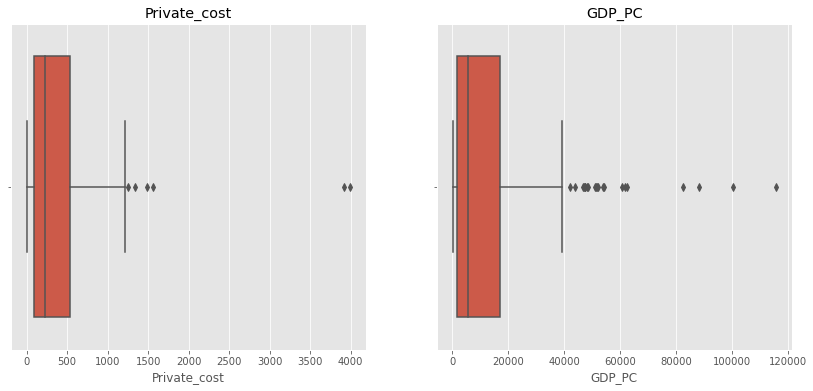

,skew,kurt
Anxiety_disorder,0.550010,0.608307
Bipolar_disorder,0.251188,0.371838
Depressive_disorders,0.468465,0.085916
Dermatitis,-0.361964,-0.284530
Musculoskeletal_disorders,0.307942,-0.931164
Public_cost,1.839094,2.719467
Private_cost,4.235344,24.995237
GDP_PC,2.219867,5.422459
per_total_agriculture,0.653955,-0.703915
per_total_employment,0.285899,-0.274244


In [26]:
df_11 = merge2complete('2011')
eval_outliers(df_11,['Private_cost','GDP_PC'])

In [27]:
# Remove outliers as per plots above:Private_cost > 3500 & GDP_per_cap > 80000)
df_11_no = df_11.drop(df_11[df_11['Private_cost'] > 3500].index)
df_11_no.drop(df_11_no[df_11_no['GDP_PC'] > 80000].index,inplace = True)

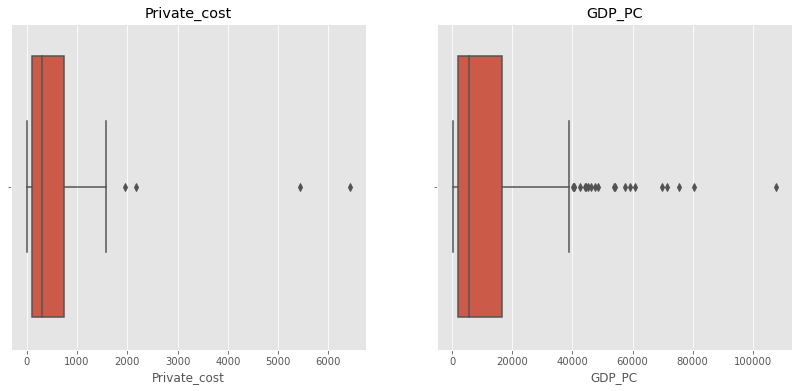

,skew,kurt
Anxiety_disorder,0.363360,0.183601
Bipolar_disorder,0.171680,0.250780
Depressive_disorders,0.244546,-0.390099
Dermatitis,-0.467853,-0.241363
Musculoskeletal_disorders,0.229870,-0.958559
Public_cost,1.631219,1.799283
Private_cost,4.846133,31.773842
GDP_PC,2.105048,4.674310
per_total_agriculture,0.849607,-0.275752
per_total_employment,0.155255,-0.351983


In [28]:
df_17 = merge2complete('2017')
eval_outliers(df_17,['Private_cost','GDP_PC'])

In [29]:
#let's see if we have the same outliers in both data-sets:

# For 2011

pd.concat([df_11.loc[df_11.Private_cost > 3500],df_11.loc[df_11.GDP_PC > 80000]])

,Anxiety_disorder,Bipolar_disorder,Depressive_disorders,Dermatitis,Musculoskeletal_disorders,Public_cost,Private_cost,GDP_PC,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Weekly_work_hours,Pop_Over15,Week_hours_PC
location_name,,,,,,,,,,,,,,,,,
Liberia,546.592086,49.656894,4183.597501,4791.624410,2364.788293,1235.321289,3986.635742,596.897081,46.439999,73.839996,10.810000,42.750000,75.529999,2.24,74613436.0,2291263.0,32.564326
Switzerland,828.742223,62.869998,4806.902201,3253.039580,5676.299312,1924.072510,3916.969971,88415.628032,3.510000,64.489998,22.280001,74.209999,67.459999,4.40,161090739.0,6728881.0,23.940197
Luxembourg,735.714819,61.670868,3880.999183,3291.846818,4910.542012,4802.062988,944.476929,115761.507705,1.230000,54.070000,13.360000,85.410004,56.849998,4.90,8810917.0,428148.0,20.579139
Norway,907.309019,59.554391,3526.220844,3604.407771,5091.140820,4636.580566,855.496582,100600.562408,2.370000,63.110001,20.250000,77.379997,65.199997,3.22,87927758.0,4027931.0,21.829509
Qatar,703.244860,61.305339,5466.014379,5052.915012,4378.810274,1459.370605,524.975403,82409.577333,1.360000,86.330002,54.110001,44.540001,86.820000,0.56,76430339.0,1769481.0,43.193648
Switzerland,828.742223,62.869998,4806.902201,3253.039580,5676.299312,1924.072510,3916.969971,88415.628032,3.510000,64.489998,22.280001,74.209999,67.459999,4.40,161090739.0,6728881.0,23.940197


In [30]:
# For 2017

pd.concat([df_17.loc[df_17.Private_cost > 3500],df_17.loc[df_17.GDP_PC > 65000]])

,Anxiety_disorder,Bipolar_disorder,Depressive_disorders,Dermatitis,Musculoskeletal_disorders,Public_cost,Private_cost,GDP_PC,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Weekly_work_hours,Pop_Over15,Week_hours_PC
location_name,,,,,,,,,,,,,,,,,
Liberia,569.510978,51.687567,4411.779660,4933.904862,2528.758085,2044.470947,6422.114746,698.701764,43.220001,74.250000,10.39,46.400002,76.540001,3.00,90190027.0,2751804.0,32.774873
Switzerland,802.672186,61.433026,4722.200520,3222.047159,5755.426880,2501.819824,5426.354492,80449.994513,3.110000,65.099998,20.52,76.379997,68.379997,4.80,170813602.0,7194841.0,23.741123
Iceland,716.632742,61.883138,3205.778103,3265.699416,4977.676623,3880.167480,859.566650,71310.939256,3.760000,74.540001,17.48,78.760002,76.639999,2.74,7935561.0,274756.0,28.882212
Ireland,900.031276,49.971683,5251.469469,3260.744705,4876.256807,4088.266846,1528.564941,69822.347085,5.050000,58.020000,18.84,76.110001,62.200001,6.71,78306739.0,3768835.0,20.777439
Luxembourg,715.824326,60.967736,3890.642072,3288.160994,5022.600800,4976.985840,812.346924,107627.151007,1.390000,55.430000,10.76,87.849998,58.669998,5.52,10365801.0,500534.0,20.709484
Norway,879.752571,58.813050,3787.399463,3596.558229,5178.138695,5546.387695,969.524353,75496.754058,2.060000,60.950001,19.41,78.529999,63.599998,4.16,91419749.0,4344523.0,21.042528
Switzerland,802.672186,61.433026,4722.200520,3222.047159,5755.426880,2501.819824,5426.354492,80449.994513,3.110000,65.099998,20.52,76.379997,68.379997,4.80,170813602.0,7194841.0,23.741123


In [31]:
#For simplification, let's remove the same outliers for 2017 as in 2011
df_17_no = df_17.drop(index = ['Liberia','Switzerland','Luxembourg','Norway','Qatar','Switzerland'])

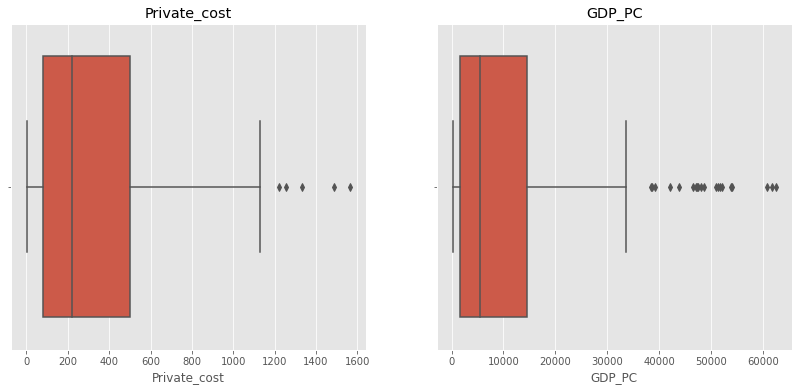

,skew,kurt
Anxiety_disorder,0.578913,0.789370
Bipolar_disorder,0.268552,0.299594
Depressive_disorders,0.493887,0.087023
Dermatitis,-0.381034,-0.181959
Musculoskeletal_disorders,0.348836,-0.884692
Public_cost,1.790133,2.231854
Private_cost,1.438502,1.807212
GDP_PC,1.607609,1.422193
per_total_agriculture,0.639339,-0.717254
per_total_employment,0.279086,-0.288685


In [32]:
#Re-evaluate whiskers, skew and kurt:
eval_outliers(df_11_no,['Private_cost','GDP_PC'])

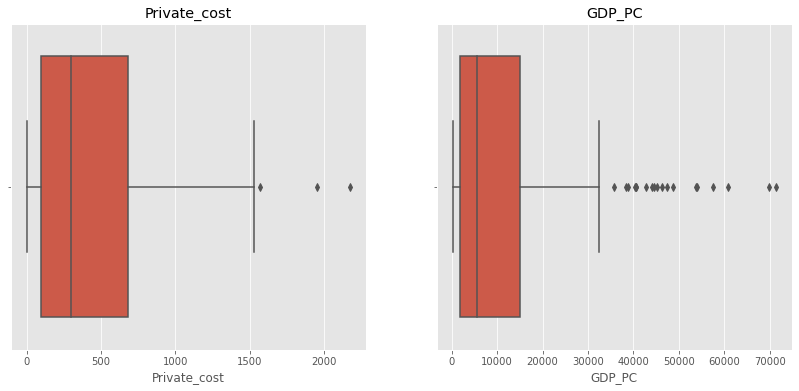

,skew,kurt
Anxiety_disorder,0.390268,0.297504
Bipolar_disorder,0.191515,0.174706
Depressive_disorders,0.271468,-0.407986
Dermatitis,-0.492789,-0.122941
Musculoskeletal_disorders,0.265213,-0.928701
Public_cost,1.685168,1.902169
Private_cost,1.331466,1.377258
GDP_PC,1.791608,2.538514
per_total_agriculture,0.838270,-0.293584
per_total_employment,0.128985,-0.414446


In [33]:
eval_outliers(df_17_no,['Private_cost','GDP_PC'])

### Fill out NA's

In [34]:
pd.DataFrame({'#NA: 2011': df_11_no.isna().sum(), '#NA: 2017':df_17_no.isna().sum()})

,#NA: 2011,#NA: 2017
Anxiety_disorder,0,0
Bipolar_disorder,0,0
Depressive_disorders,0,0
Dermatitis,0,0
Musculoskeletal_disorders,0,0
Public_cost,5,6
Private_cost,5,6
GDP_PC,2,3
per_total_agriculture,0,0
per_total_employment,0,0


In [44]:
df_11_gb = (
    df_11_no
    .pipe(predict_missing, 'Public_cost')
    .pipe(predict_missing, 'Private_cost')
    .pipe(predict_missing, 'GDP_PC')
)

df_17_gb = (
    df_17_no
    .pipe(predict_missing, 'Public_cost')
    .pipe(predict_missing, 'Private_cost')
    .pipe(predict_missing, 'GDP_PC')
    .pipe(predict_missing, 'Pop_Over15')
    .pipe(predict_missing, 'Week_hours_PC')
)

In [45]:
pd.DataFrame({'#NA: 2011': df_11_gb.isna().sum(), '#NA: 2017':df_17_gb.isna().sum()})

,#NA: 2011,#NA: 2017
Anxiety_disorder,0,0
Bipolar_disorder,0,0
Depressive_disorders,0,0
Dermatitis,0,0
Musculoskeletal_disorders,0,0
Public_cost,0,0
Private_cost,0,0
GDP_PC,0,0
per_total_agriculture,0,0
per_total_employment,0,0


### Feature Engineering

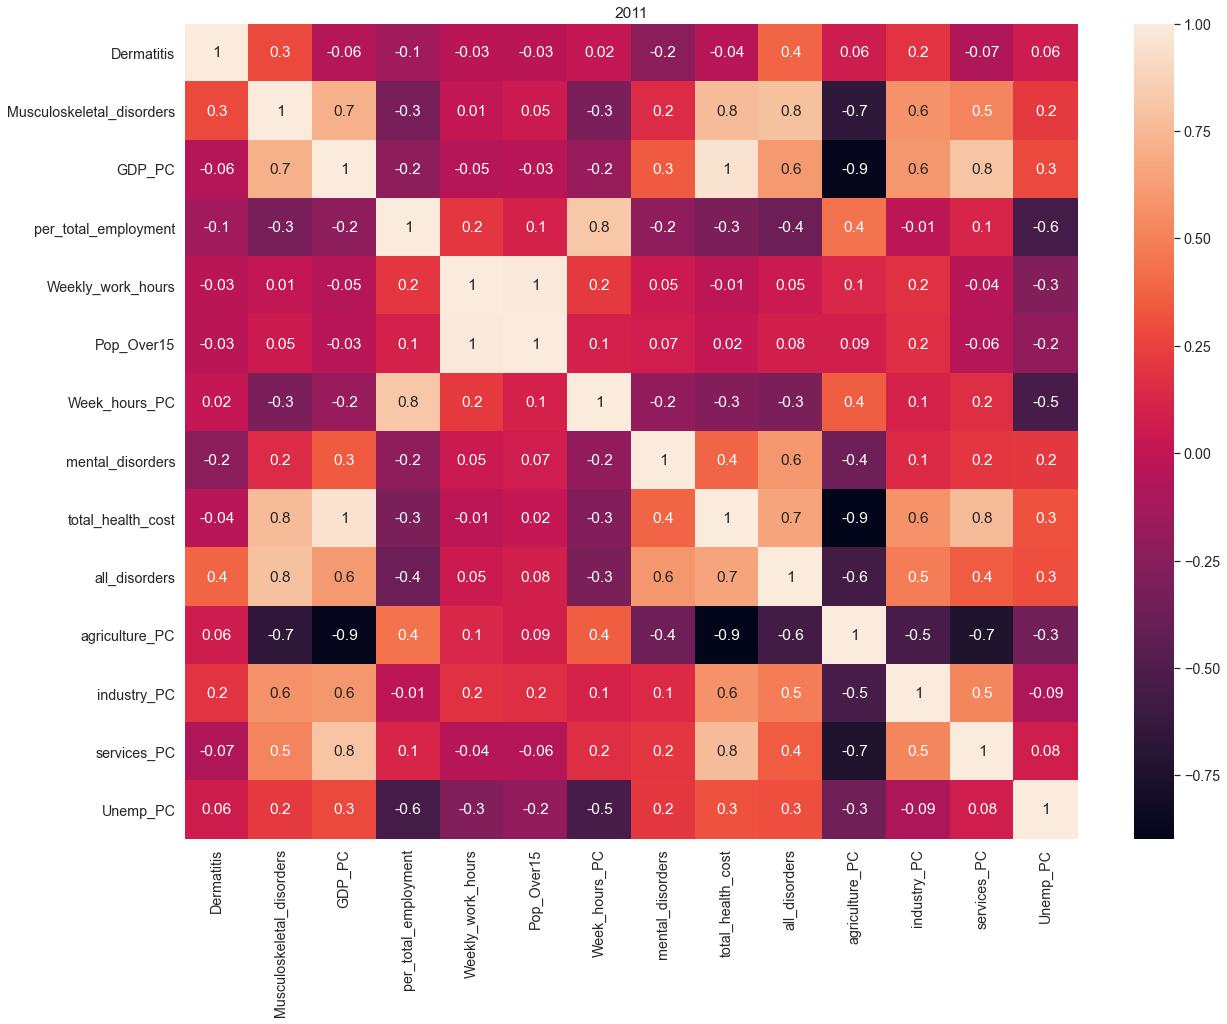

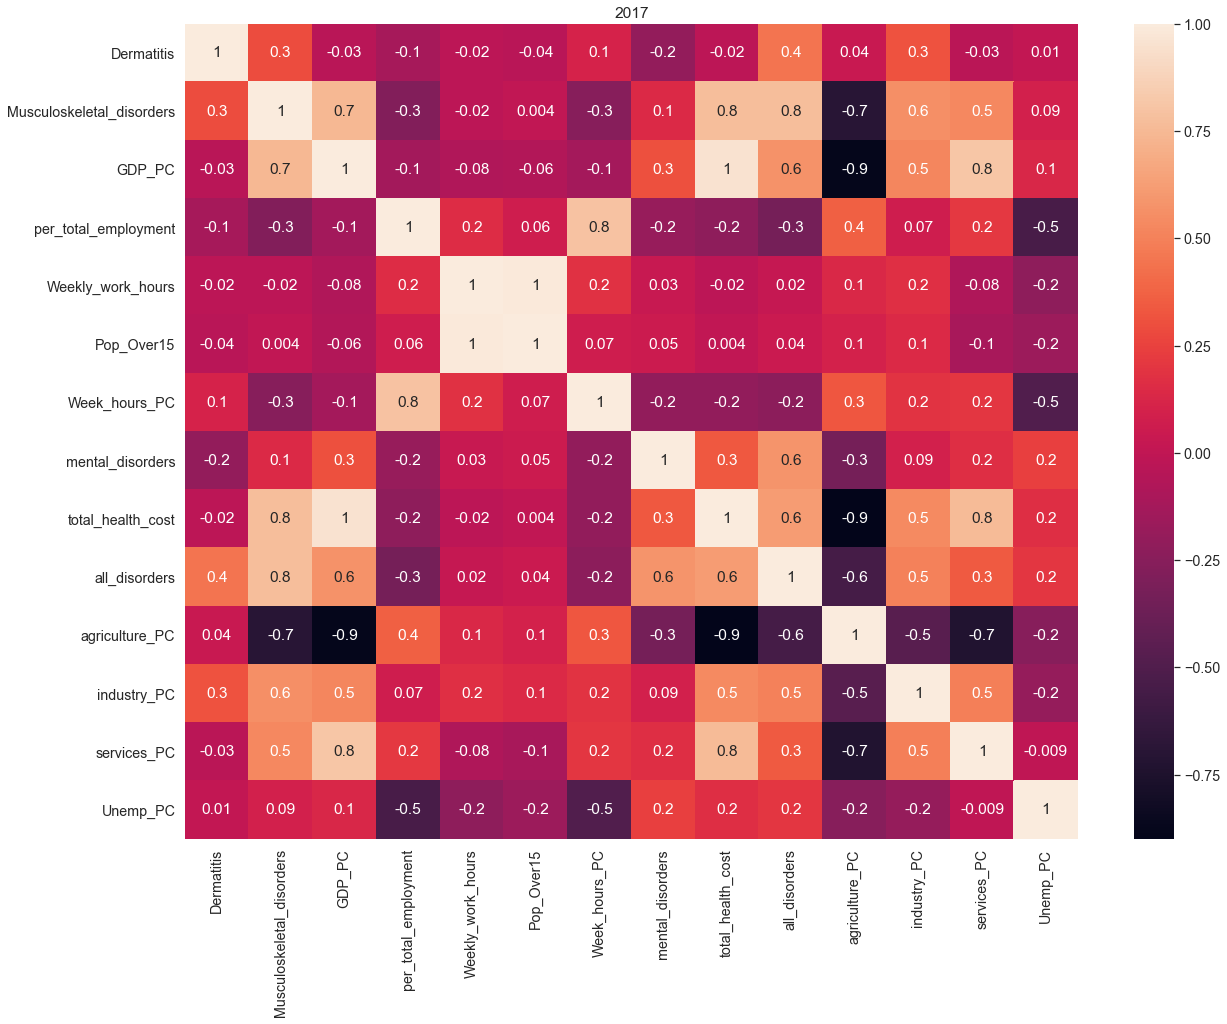

In [46]:
df_11_feat = feature_df(df_11_gb,'2011')
df_17_feat = feature_df(df_17_gb,'2017')

In [ ]:
df_17_feat

### Cluster Analysis

Scenario 1: __Delta between 2011 and 2017__, considering the following features:

1. Per_Total_employment
2. Unem_percapita
3. Week_hours_PC
4. GDP_per_cap
5. Total_health_cost
6. All_disorders

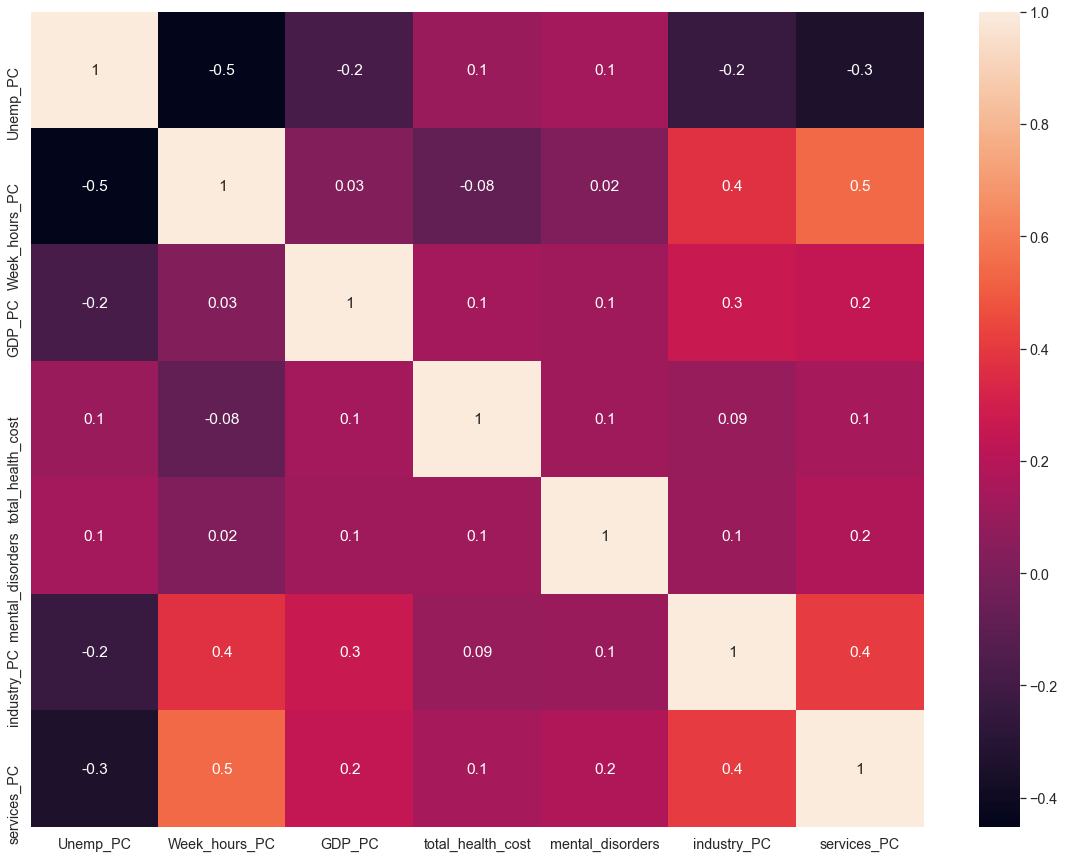

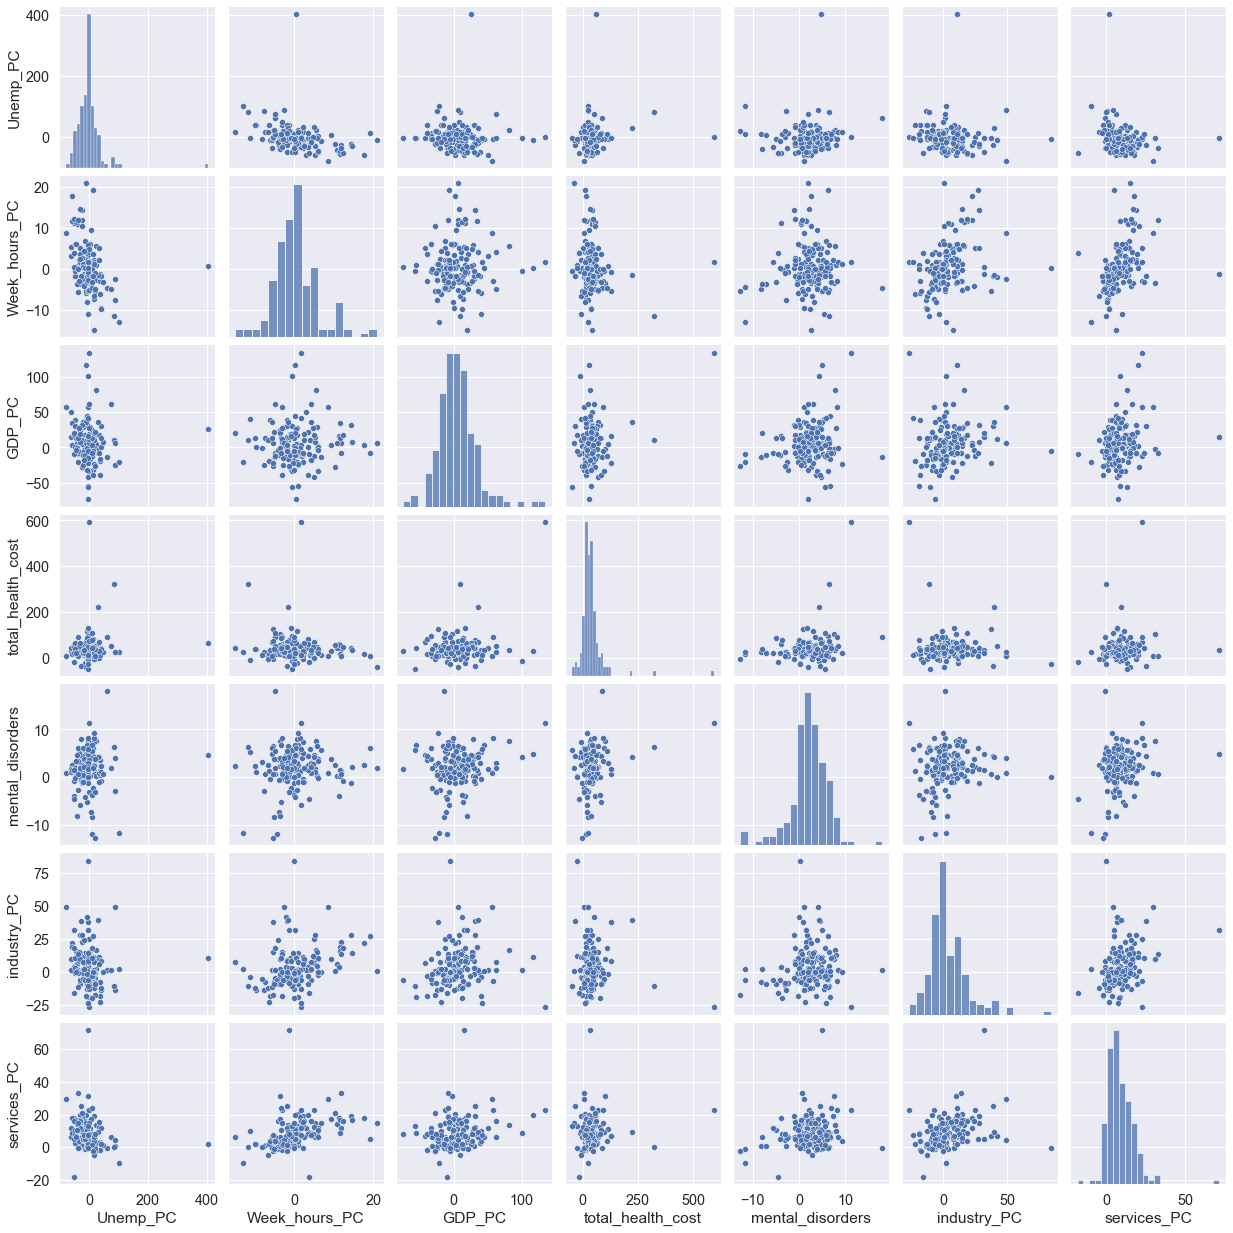

,count,mean,std,min,25%,50%,75%,max
Unemp_PC,152.0,-1.463228,44.333552,-76.879646,-20.910456,-4.367107,10.755522,403.013315
Week_hours_PC,152.0,0.460505,5.790090,-15.004738,-3.038225,-0.059955,2.655946,20.831629
GDP_PC,152.0,5.421835,28.733629,-73.792238,-11.392430,2.294880,17.817770,134.535513
total_health_cost,152.0,40.491998,60.645065,-47.942598,16.122290,30.282650,48.013396,593.110361
mental_disorders,152.0,2.095794,4.045919,-12.664532,0.350549,2.223765,4.435538,17.937969
industry_PC,152.0,3.710917,15.179589,-26.879486,-5.669408,1.061904,10.526754,83.868529
services_PC,152.0,8.767210,9.203318,-18.188675,3.067852,7.198086,13.094379,71.794926


In [99]:
df_sc_1 = (100*(df_17_feat - df_11_feat)/(df_11_feat))[['Unemp_PC','Week_hours_PC',\
                                                'GDP_PC','total_health_cost','mental_disorders','industry_PC','services_PC']]

    
    
#correlation map
sns.set(font_scale=1.3)
df_corr = df_sc_1.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g')

sns.pairplot(df_sc_1)

plt.show()

df_sc_1.describe().T

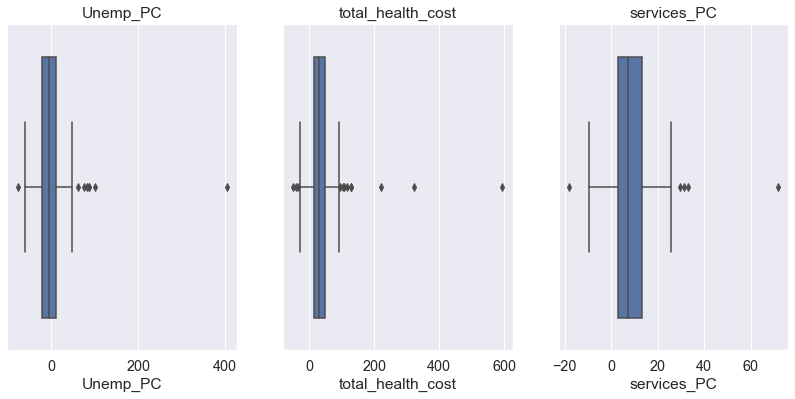

,skew,kurt
Unemp_PC,5.232171,45.596000
Week_hours_PC,0.769560,1.744852
GDP_PC,1.174760,4.056467
total_health_cost,5.907388,48.430387
Musculoskeletal_disorders,1.704973,6.557232
industry_PC,1.569084,5.187694
services_PC,2.310559,14.081184


In [84]:
eval_outliers(df_sc_1,['Unemp_PC','total_health_cost','services_PC'])

In [100]:
df_sc_1.drop(df_sc_1[df_sc_1['Unemp_PC'] > 200].index,inplace = True)
df_sc_1.drop(df_sc_1[df_sc_1['total_health_cost'] > 200].index,inplace = True)
df_sc_1.drop(df_sc_1[df_sc_1['services_PC'] > 60].index,inplace = True)

In [111]:
df_sc_1.describe().T

,count,mean,std,min,25%,50%,75%,max
Unemp_PC,147.0,-4.982879,29.057079,-76.879646,-22.496535,-4.795313,9.190463,100.978539
Week_hours_PC,147.0,0.559378,5.796965,-15.004738,-3.057966,-0.053060,3.199402,20.831629
GDP_PC,147.0,4.100647,26.981433,-73.792238,-11.540956,1.424347,17.358914,116.802987
total_health_cost,147.0,33.489407,29.868475,-47.942598,16.037338,29.279410,46.348446,128.548688
mental_disorders,147.0,1.953581,4.010040,-12.664532,0.345280,2.182158,4.138688,17.937969
industry_PC,147.0,3.543488,14.702583,-23.363370,-5.577660,1.048037,10.223786,83.868529
services_PC,147.0,8.342688,7.616280,-18.188675,3.137812,7.075549,13.001358,33.154890


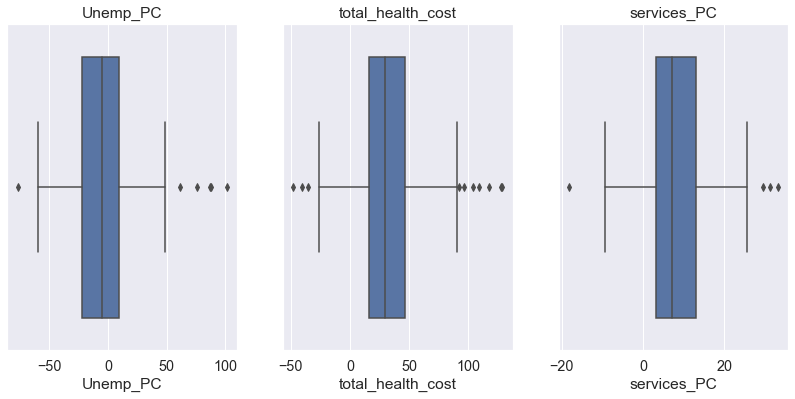

,skew,kurt
Unemp_PC,0.690730,1.789864
Week_hours_PC,0.804849,1.697404
GDP_PC,0.842996,2.816151
total_health_cost,0.562584,1.439465
Musculoskeletal_disorders,1.057875,3.096742
industry_PC,1.745767,6.249965
services_PC,0.423528,1.294621


In [86]:
eval_outliers(df_sc_1,['Unemp_PC','total_health_cost','services_PC'])

### Visual Exploration

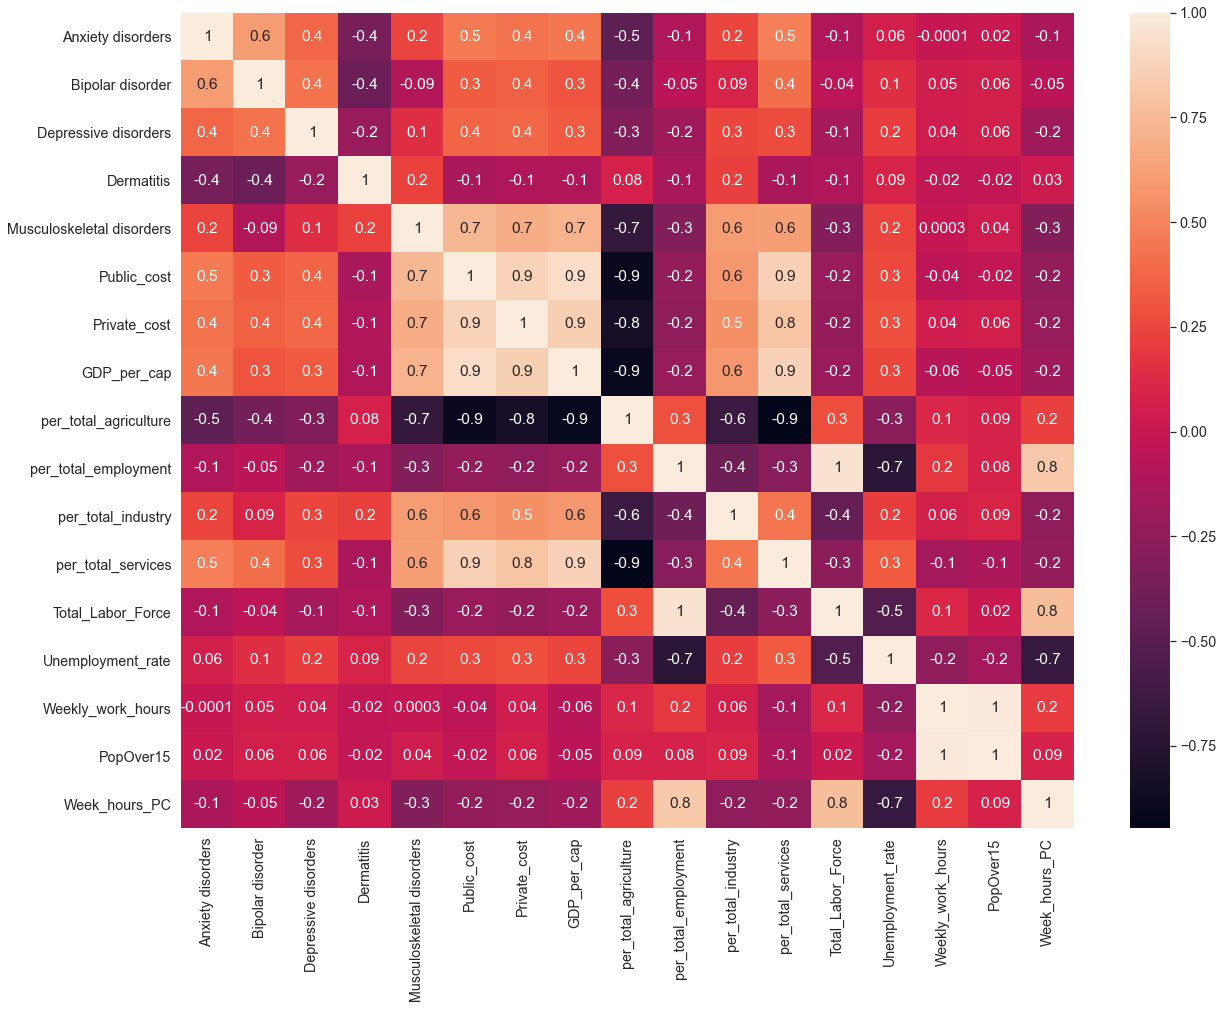

In [27]:
#correlation map
sns.set(font_scale=1.3)
df_corr = complete.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g') 
plt.show()

### 2 update

* __per_total_agriculture__ (% of people out of the employed people that work in agriculture) seems to be negatively correlated with all the features. It is also strongly negatively (-0.9) correlated to __per_total_services, GDP_per_cap and Public Cost__ --> meaning that we probably should pick one pf them to include in a cluster analysis (check below subplots)<br><br>
* __Only three diseases__ seem to have relatively high |correlation| with other variables (0.7-0.8):
1. __Headache disorders__: >=0.7 (GDP_per_cap, Private_cost, Public_cost, __Musculoskeleton__)
2. __Musculoskeleton__: >=0.7 (per_total_agriculture, GDP_per_cap, Public_cost, __Stroke__)

--> retirar headache, stroke, somar mentais
--> dados que faltam:
1. consumo de alcool & tabaco (dados +)


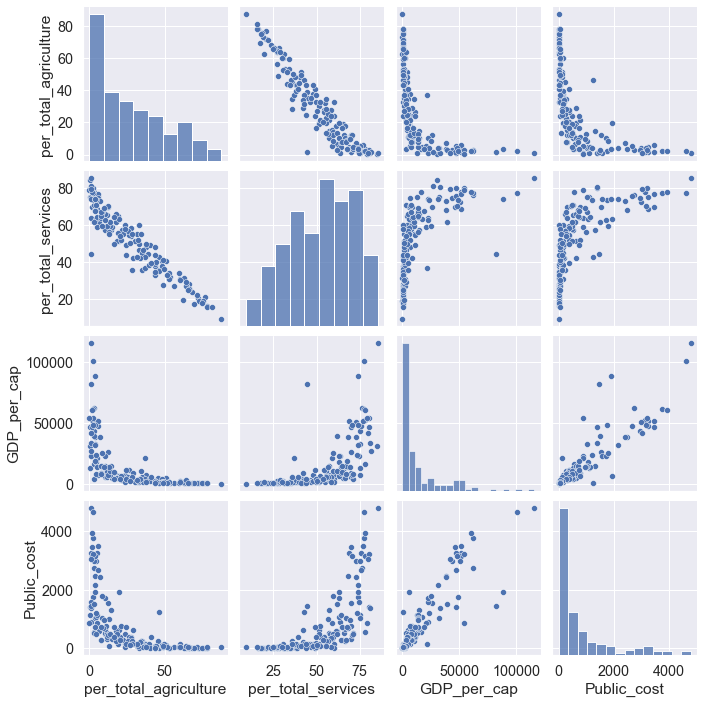

In [28]:
sns.pairplot(complete[['per_total_agriculture','per_total_services','GDP_per_cap','Public_cost']])
plt.show()

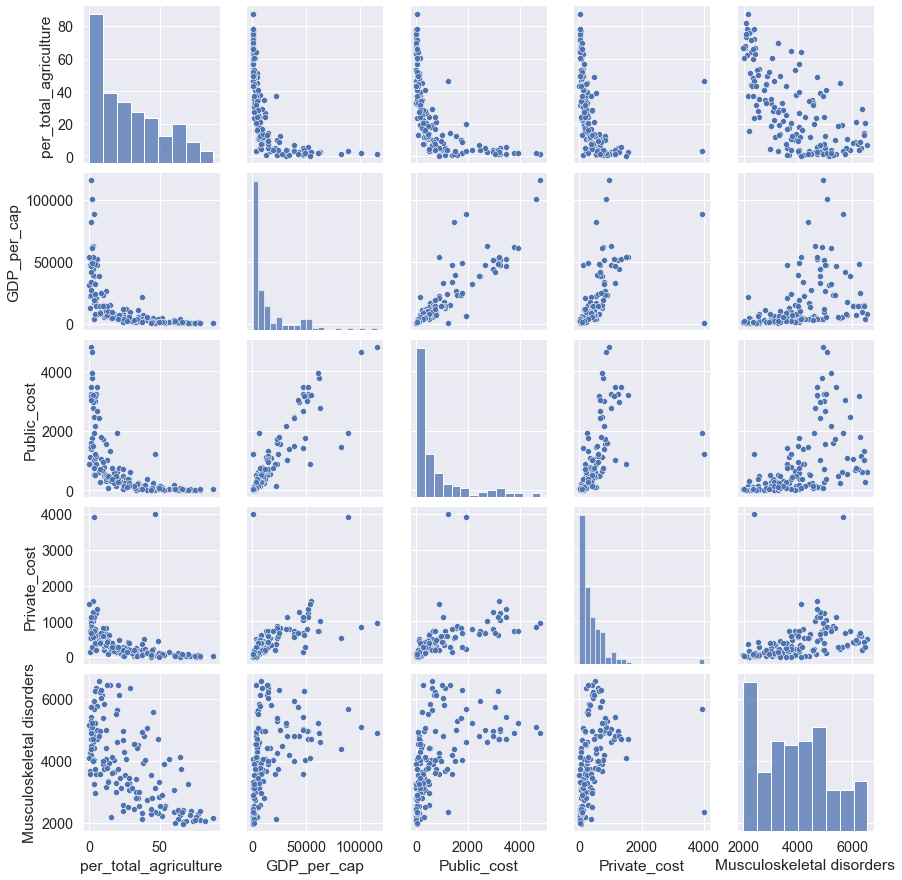

In [29]:
sns.pairplot(complete[['per_total_agriculture','GDP_per_cap','Public_cost','Private_cost','Musculoskeletal disorders']])
plt.show()

### Missing Values

In [30]:
#missing values (% of total):
complete.isna().sum()

Anxiety disorders            0
Bipolar disorder             0
Depressive disorders         0
Dermatitis                   0
Musculoskeletal disorders    0
Public_cost                  5
Private_cost                 5
GDP_per_cap                  2
per_total_agriculture        0
per_total_employment         0
per_total_industry           0
per_total_services           0
Total_Labor_Force            0
Unemployment_rate            0
Weekly_work_hours            0
PopOver15                    0
Week_hours_PC                0
dtype: int64

In [40]:
#Our missing values
complete[complete.isna().any(axis=1)]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Weekly_work_hours,PopOver15,Week_hours_PC
location_name,,,,,,,,,,,,,,,,,
Guam,628.860288,26.393240,2947.881845,5318.615132,5149.008697,NaN,NaN,30859.404353,0.310000,56.990002,14.920000,84.769997,65.739998,13.30,2861313.0,116488.0,24.563157
Montenegro,555.870241,45.255394,3252.991054,5523.438917,5773.516912,NaN,NaN,7329.026063,5.470000,38.910000,19.549999,74.980003,48.439999,19.67,7973046.0,501506.0,15.898207
Puerto Rico,657.284541,74.289970,3446.179524,5449.261183,4469.123640,NaN,NaN,27278.883050,1.320000,37.009998,17.200001,81.480003,43.910000,15.70,42660824.0,2933193.0,14.544159
Somalia,495.493143,53.780194,3473.922771,4316.467890,2070.611927,NaN,NaN,NaN,81.680000,41.160000,2.640000,15.680000,47.520000,13.38,95771203.0,6419260.0,14.919353
South Sudan,663.511410,53.260778,3464.444427,4389.049946,2119.947286,NaN,NaN,1516.403915,62.529999,63.990002,17.889999,19.580000,73.199997,12.57,128753413.0,5563020.0,23.144517
Syrian Arab Republic,854.723817,67.519896,4030.946695,4359.897297,3309.178846,82.711349,97.69017,NaN,13.230000,39.509998,31.430000,55.340000,43.230000,8.60,223872008.0,13319955.0,16.807265


In [32]:
complete_no_na = complete.dropna()

In [33]:
complete_no_na.info()
#data size is 96% the size of the original (4% data loss)

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, Afghanistan to Zimbabwe
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Anxiety disorders          151 non-null    float64
 1   Bipolar disorder           151 non-null    float64
 2   Depressive disorders       151 non-null    float64
 3   Dermatitis                 151 non-null    float64
 4   Musculoskeletal disorders  151 non-null    float64
 5   Public_cost                151 non-null    float64
 6   Private_cost               151 non-null    float64
 7   GDP_per_cap                151 non-null    float64
 8   per_total_agriculture      151 non-null    float64
 9   per_total_employment       151 non-null    float64
 10  per_total_industry         151 non-null    float64
 11  per_total_services         151 non-null    float64
 12  Total_Labor_Force          151 non-null    float64
 13  Unemployment_rate          151 non-null 

### Using Gradient Boosting to fill in NA's

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
def predict_missing(df, evaluated_column,cols):
    """ Predicts and updates the missing values for the different features. """
    
    # removes the evaluated feature
    cols.remove(evaluated_column)
    
    # defines the data to be used using the gradiant boosting method
    gb_data = df.select_dtypes(exclude=['object']).drop(columns = cols)
    
    # divides the data in missing and complete values
    feature_na = gb_data.loc[gb_data[evaluated_column].isna()]
    feature = gb_data.loc[~gb_data[evaluated_column].isna()]
    
    # defines the training data
    x_train = feature.drop(columns = evaluated_column)
    y_train = feature.copy().pop(evaluated_column)
    
    # fits the model
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(x_train, y_train)
    
    # predicts missing values
    x_predict = feature_na.drop(columns = evaluated_column)
    pred = pd.DataFrame(gb.predict(x_predict), index=x_predict.index, columns=[f'{evaluated_column}_na'])
    
    # fills the na values
    df = df.merge(pred, left_index=True, right_index=True, how='left')
    df.loc[df[evaluated_column].isna(), evaluated_column] = df[f'{evaluated_column}_na']
    df.drop(columns = [f'{evaluated_column}_na'], inplace=True)
    
    return df

In [36]:
complete_gb = (
    complete
    .pipe(predict_missing, 'Public_cost')
    .pipe(predict_missing, 'Private_cost')
    .pipe(predict_missing, 'GDP_per_cap')
)

### Check Distribution after Gradient Boosting
1. Feature Public_cost has negative values, which makes no sense
2. For these values, we will replace each negative value by 0


In [78]:
complete_gb.describe().T

,count,mean,std,min,25%,50%,75%,max
Anxiety disorders,157.0,6.213794e+02,1.289619e+02,3.310676e+02,5.225292e+02,6.135191e+02,7.032449e+02,1.103210e+03
Bipolar disorder,157.0,5.564361e+01,1.606044e+01,1.726223e+01,4.677635e+01,5.513208e+01,6.466857e+01,1.106297e+02
Depressive disorders,157.0,3.899776e+03,1.214476e+03,1.243609e+03,3.079531e+03,3.700700e+03,4.758966e+03,8.106151e+03
Dermatitis,157.0,4.685807e+03,8.003630e+02,2.788217e+03,4.359897e+03,4.765304e+03,5.194157e+03,6.474561e+03
Musculoskeletal disorders,157.0,3.874012e+03,1.281833e+03,1.961085e+03,2.786073e+03,3.764596e+03,4.813597e+03,6.569525e+03
Public_cost,157.0,7.827321e+02,1.067011e+03,-4.429318e+01,6.313517e+01,3.023157e+02,1.035864e+03,4.802063e+03
Private_cost,157.0,3.954741e+02,5.279416e+02,2.031960e+00,8.319632e+01,2.273871e+02,5.726277e+02,3.986636e+03
GDP_per_cap,157.0,1.470416e+04,2.094519e+04,2.495780e+02,1.516404e+03,5.554179e+03,1.645835e+04,1.157615e+05
per_total_agriculture,157.0,2.792892e+01,2.362269e+01,1.100000e-01,5.730000e+00,2.257000e+01,4.372000e+01,8.775000e+01
per_total_employment,157.0,5.732389e+01,1.190535e+01,3.309000e+01,4.928000e+01,5.720000e+01,6.449000e+01,8.694000e+01


In [51]:
complete_gb[complete.isna().any(axis=1)]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Weekly_work_hours,PopOver15,Week_hours_PC
location_name,,,,,,,,,,,,,,,,,
Guam,628.860288,26.393240,2947.881845,5318.615132,5149.008697,2648.628889,815.019971,30859.404353,0.310000,56.990002,14.920000,84.769997,65.739998,13.30,2861313.0,116488.0,24.563157
Montenegro,555.870241,45.255394,3252.991054,5523.438917,5773.516912,1098.144475,697.260221,7329.026063,5.470000,38.910000,19.549999,74.980003,48.439999,19.67,7973046.0,501506.0,15.898207
Puerto Rico,657.284541,74.289970,3446.179524,5449.261183,4469.123640,1301.193179,673.649649,27278.883050,1.320000,37.009998,17.200001,81.480003,43.910000,15.70,42660824.0,2933193.0,14.544159
Somalia,495.493143,53.780194,3473.922771,4316.467890,2070.611927,-43.204667,32.414323,495.299975,81.680000,41.160000,2.640000,15.680000,47.520000,13.38,95771203.0,6419260.0,14.919353
South Sudan,663.511410,53.260778,3464.444427,4389.049946,2119.947286,-44.293176,31.824863,1516.403915,62.529999,63.990002,17.889999,19.580000,73.199997,12.57,128753413.0,5563020.0,23.144517
Syrian Arab Republic,854.723817,67.519896,4030.946695,4359.897297,3309.178846,82.711349,97.690170,6432.226549,13.230000,39.509998,31.430000,55.340000,43.230000,8.60,223872008.0,13319955.0,16.807265


In [52]:
complete_gb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157 entries, Afghanistan to Zimbabwe
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Anxiety disorders          157 non-null    float64
 1   Bipolar disorder           157 non-null    float64
 2   Depressive disorders       157 non-null    float64
 3   Dermatitis                 157 non-null    float64
 4   Musculoskeletal disorders  157 non-null    float64
 5   Public_cost                157 non-null    float64
 6   Private_cost               157 non-null    float64
 7   GDP_per_cap                157 non-null    float64
 8   per_total_agriculture      157 non-null    float64
 9   per_total_employment       157 non-null    float64
 10  per_total_industry         157 non-null    float64
 11  per_total_services         157 non-null    float64
 12  Total_Labor_Force          157 non-null    float64
 13  Unemployment_rate          157 non-null 

In [53]:
complete_gb.skew()

Anxiety disorders            0.550010
Bipolar disorder             0.251188
Depressive disorders         0.468465
Dermatitis                  -0.361964
Musculoskeletal disorders    0.307942
Public_cost                  1.797248
Private_cost                 4.203980
GDP_per_cap                  2.239013
per_total_agriculture        0.653955
per_total_employment         0.285899
per_total_industry           0.329752
per_total_services          -0.306074
Total_Labor_Force            0.260776
Unemployment_rate            1.412328
Weekly_work_hours            9.200545
PopOver15                    8.163477
Week_hours_PC                0.985382
dtype: float64

In [54]:
complete_gb.kurt()

Anxiety disorders             0.608307
Bipolar disorder              0.371838
Depressive disorders          0.085916
Dermatitis                   -0.284530
Musculoskeletal disorders    -0.931164
Public_cost                   2.580049
Private_cost                 25.032231
GDP_per_cap                   5.525544
per_total_agriculture        -0.703915
per_total_employment         -0.274244
per_total_industry            0.970704
per_total_services           -0.893237
Total_Labor_Force            -0.239545
Unemployment_rate             1.929349
Weekly_work_hours            91.542004
PopOver15                    70.268097
Week_hours_PC                 1.945901
dtype: float64

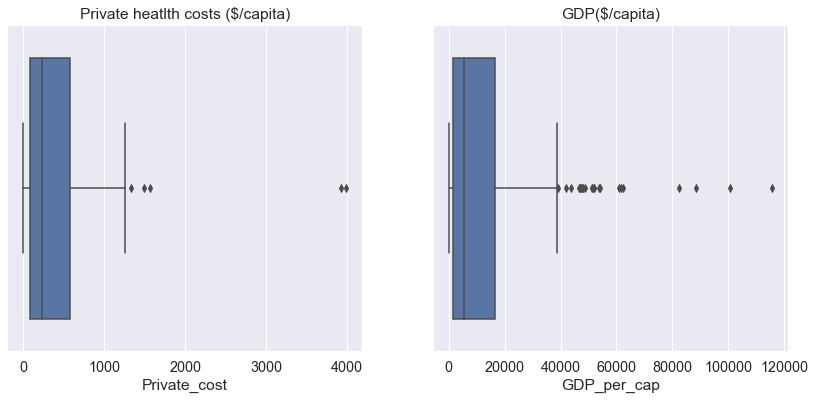

In [58]:
# check distribution of feature with highest kurtosis/skewness
fig, axes = plt.subplots(1,2, figsize = (14,6))
sns.boxplot(ax = axes[0], data = complete_gb, x = 'Private_cost').set(title='Private heatlth costs ($/capita)') 
sns.boxplot(ax = axes[1], data = complete_gb, x = 'GDP_per_cap').set(title='GDP($/capita)')
plt.show()

In [110]:
complete_gb[complete_gb.index == 'United Kingdom']

NameError: name 'complete_gb' is not defined

In [41]:
complete.loc[complete.Private_cost > 3500]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Weekly_work_hours,PopOver15
location_name,,,,,,,,,,,,,,,,
Liberia,546.592086,49.656894,4183.597501,4791.62441,2364.788293,1235.321289,3986.635742,596.897081,46.439999,73.839996,10.810000,42.750000,75.529999,2.24,74613436.0,2291263.0
Switzerland,828.742223,62.869998,4806.902201,3253.03958,5676.299312,1924.072510,3916.969971,88415.628032,3.510000,64.489998,22.280001,74.209999,67.459999,4.40,161090739.0,6728881.0


In [59]:
complete_gb.loc[complete_gb.GDP_per_cap > 80000]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Weekly_work_hours,PopOver15,Week_hours_PC
location_name,,,,,,,,,,,,,,,,,
Luxembourg,735.714819,61.670868,3880.999183,3291.846818,4910.542012,4802.062988,944.476929,115761.507705,1.23,54.070000,13.360000,85.410004,56.849998,4.90,8810917.0,428148.0,20.579139
Norway,907.309019,59.554391,3526.220844,3604.407771,5091.140820,4636.580566,855.496582,100600.562408,2.37,63.110001,20.250000,77.379997,65.199997,3.22,87927758.0,4027931.0,21.829509
Qatar,703.244860,61.305339,5466.014379,5052.915012,4378.810274,1459.370605,524.975403,82409.577333,1.36,86.330002,54.110001,44.540001,86.820000,0.56,76430339.0,1769481.0,43.193648
Switzerland,828.742223,62.869998,4806.902201,3253.039580,5676.299312,1924.072510,3916.969971,88415.628032,3.51,64.489998,22.280001,74.209999,67.459999,4.40,161090739.0,6728881.0,23.940197


In [64]:
#outliers removal
complete_no = complete_gb.drop(complete_gb[complete_gb['Private_cost'] > 3500].index)
complete_no.drop(complete_no[complete_no['GDP_per_cap'] > 80000].index,inplace = True)

### Re-evaluate statistics

In [68]:
# This is GB for missing values and Outliers according to previous cells
complete_no.skew()

Anxiety disorders            0.578913
Bipolar disorder             0.268552
Depressive disorders         0.493887
Dermatitis                  -0.381034
Musculoskeletal disorders    0.348836
Public_cost                  1.737868
Private_cost                 1.370048
GDP_per_cap                  1.626249
per_total_agriculture        0.639339
per_total_employment         0.279086
per_total_industry          -0.104446
per_total_services          -0.318386
Total_Labor_Force            0.251715
Unemployment_rate            1.384824
Weekly_work_hours            9.054090
PopOver15                    8.033515
Week_hours_PC                0.748841
dtype: float64

In [69]:
complete_no.kurt()

Anxiety disorders             0.789370
Bipolar disorder              0.299594
Depressive disorders          0.087023
Dermatitis                   -0.181959
Musculoskeletal disorders    -0.884692
Public_cost                   2.050482
Private_cost                  1.583667
GDP_per_cap                   1.490369
per_total_agriculture        -0.717254
per_total_employment         -0.288685
per_total_industry           -0.577817
per_total_services           -0.902726
Total_Labor_Force            -0.248355
Unemployment_rate             1.835929
Weekly_work_hours            88.623239
PopOver15                    68.004959
Week_hours_PC                 1.134059
dtype: float64

### Feature Engineering

In [70]:
def feature_df(df):
    
    #group all mental disordes in new variable
    df['mental_disorders'] = df['Anxiety disorders']+df['Bipolar disorder']+df['Depressive disorders']
    
    #group all costs in one single cost variable
    df['total_health_cost']=df['Private_cost']+df['Public_cost']
    
    #group all diseases in single total diseases var
    df['all_disorders'] = df['mental_disorders']+df['Musculoskeletal disorders']+df['Dermatitis']
    
    #normalize variables PER CAPITA
    #per_total_employment: Employment to population ratio, 15+, total (%)
    #per_total_sector: Employment in each sector (% of total employment)
    
    df['agriculture_percap'] = (df['per_total_employment']*df['per_total_agriculture'])/10000
    df['industry_percap'] = (df['per_total_employment']*df['per_total_industry'])/10000
    df['services_percap'] = (df['per_total_employment']*df['per_total_services'])/10000
    
    #unemployment is per total work force & labor force is per capita.
    df['Unemp_percapita'] = (df['Unemployment_rate']*df['Total_Labor_Force'])/10000
    
    df.drop(columns=['Anxiety disorders','Bipolar disorder','Depressive disorders',\
                     'Public_cost','Private_cost','per_total_agriculture',\
                    'per_total_industry','per_total_services',\
                    'Total_Labor_Force','Unemployment_rate'],inplace=True)
    return df

In [140]:
feat_df = feature_df(complete_no.copy())

### Correlation between Diseases
1. __Analysis__: mental __vs__ Muscu. __vs__ Dermat
2. __Results__: almost no correlation between all diseases

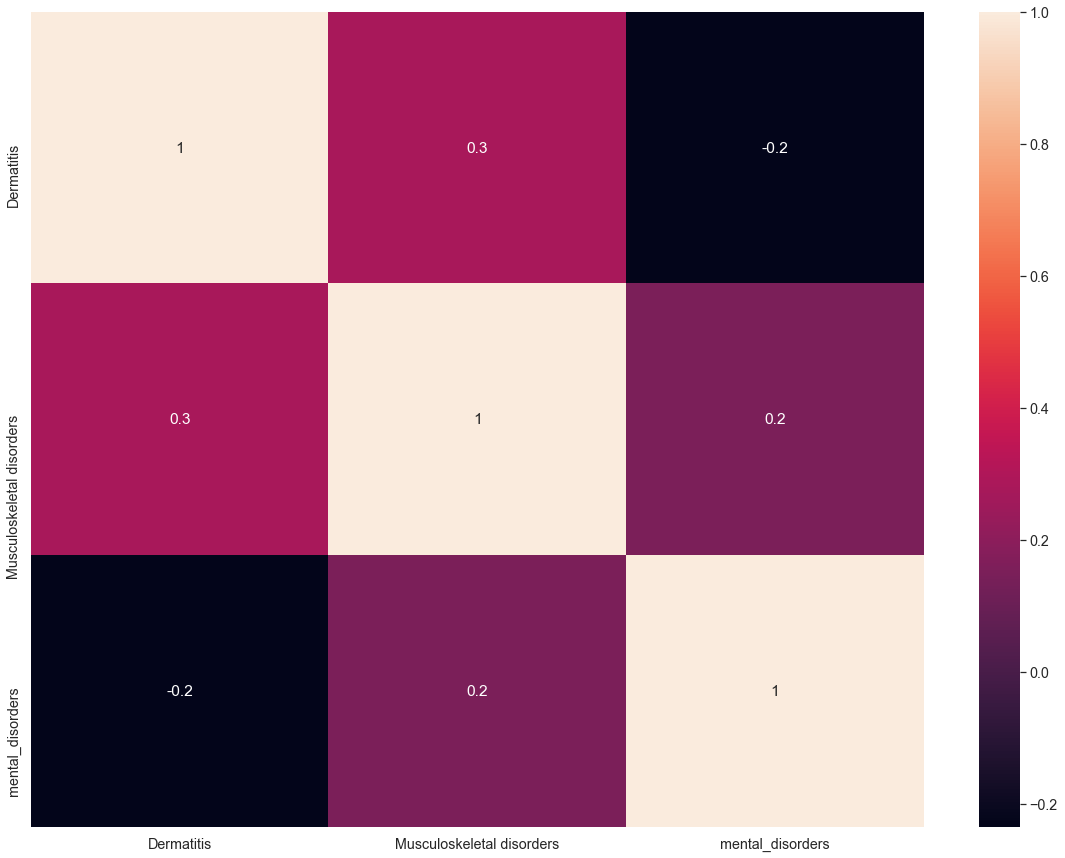

In [141]:
#correlation map:

sns.set(font_scale=1.3)
df_corr = feat_df[['Dermatitis','Musculoskeletal disorders','mental_disorders']].corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g') 
plt.show()

### Correlation between Sectors
1. __Analysis__: agriculture __vs__ industry __vs__ services
2. __Results__: Agriculture & Services have the highest correlation (-0.7)
    1. Remove agriculture

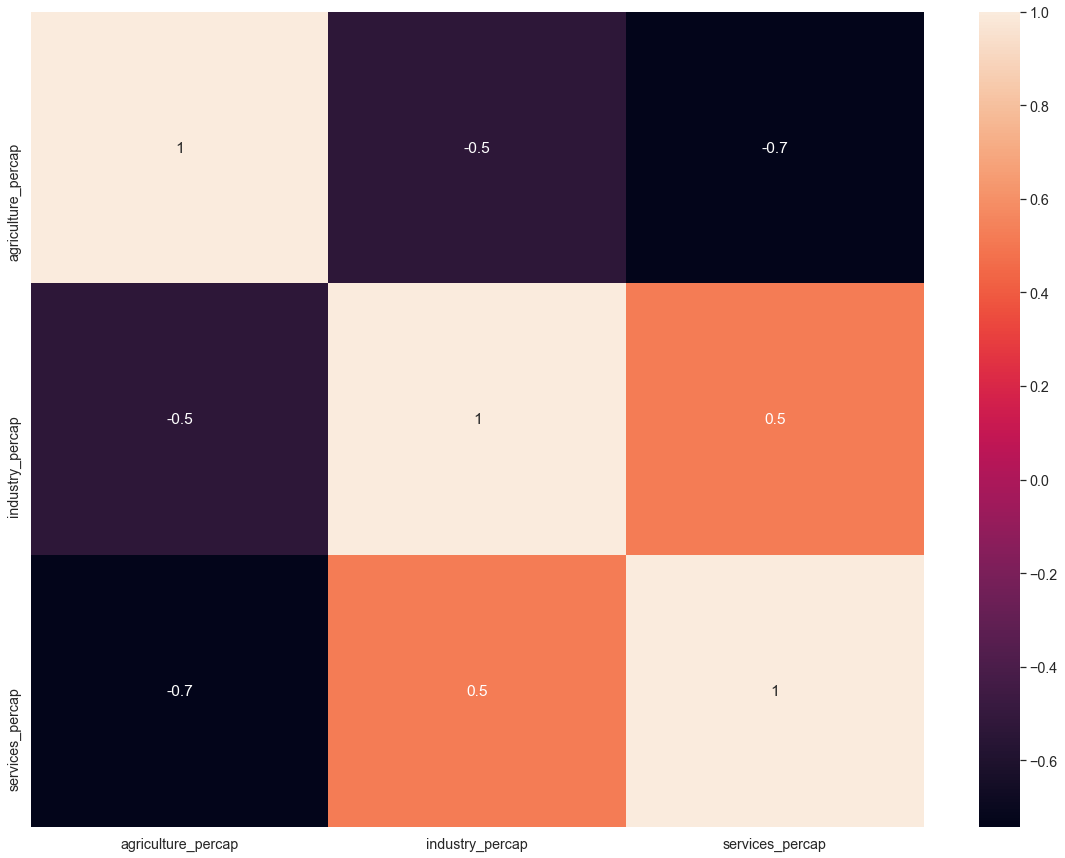

In [142]:
#correlation map:

sns.set(font_scale=1.3)
df_corr = feat_df[['agriculture_percap','industry_percap','services_percap']].corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g') 
plt.show()

### Cluster Analysis:
1. Scenario 1: __General Indicators__
    1. Per_Total_employment
    2. Unem_percapita
    3. Week_hours_PC
    4. GDP_per_cap
    5. Total_health_cost
    6. All_disorders


### Scenario 1
1. get df_sc1 (with variables to use)
2. Check distribution and correlation
3. apply transformation to normalize variables, if needed

In [72]:
df_sc1 = feature_df(complete_no.copy())[['all_disorders','total_health_cost','GDP_per_cap','Week_hours_PC','Unemp_percapita','per_total_employment']]

In [73]:
df_sc1

,all_disorders,total_health_cost,GDP_per_cap,Week_hours_PC,Unemp_percapita,per_total_employment
location_name,,,,,,
Afghanistan,11778.207734,108.015223,591.162759,15.629483,0.054972,42.259998
Albania,13976.364008,480.215637,4437.142885,18.684049,0.081055,52.020000
Algeria,13898.889198,687.132324,5462.260897,16.157766,0.042310,38.250000
Angola,12212.873448,163.096699,4615.468028,28.104602,0.056974,71.709999
Argentina,10671.427182,1852.966370,12848.864197,21.614220,0.043532,56.279999
...,...,...,...,...,...,...
Uruguay,11568.542317,1553.247559,14236.681188,22.134181,0.041558,61.709999
Uzbekistan,11537.734442,280.536118,1926.292997,23.636091,0.031305,59.480000
Vanuatu,11767.255997,78.496647,3264.537017,18.917324,0.012896,68.419998


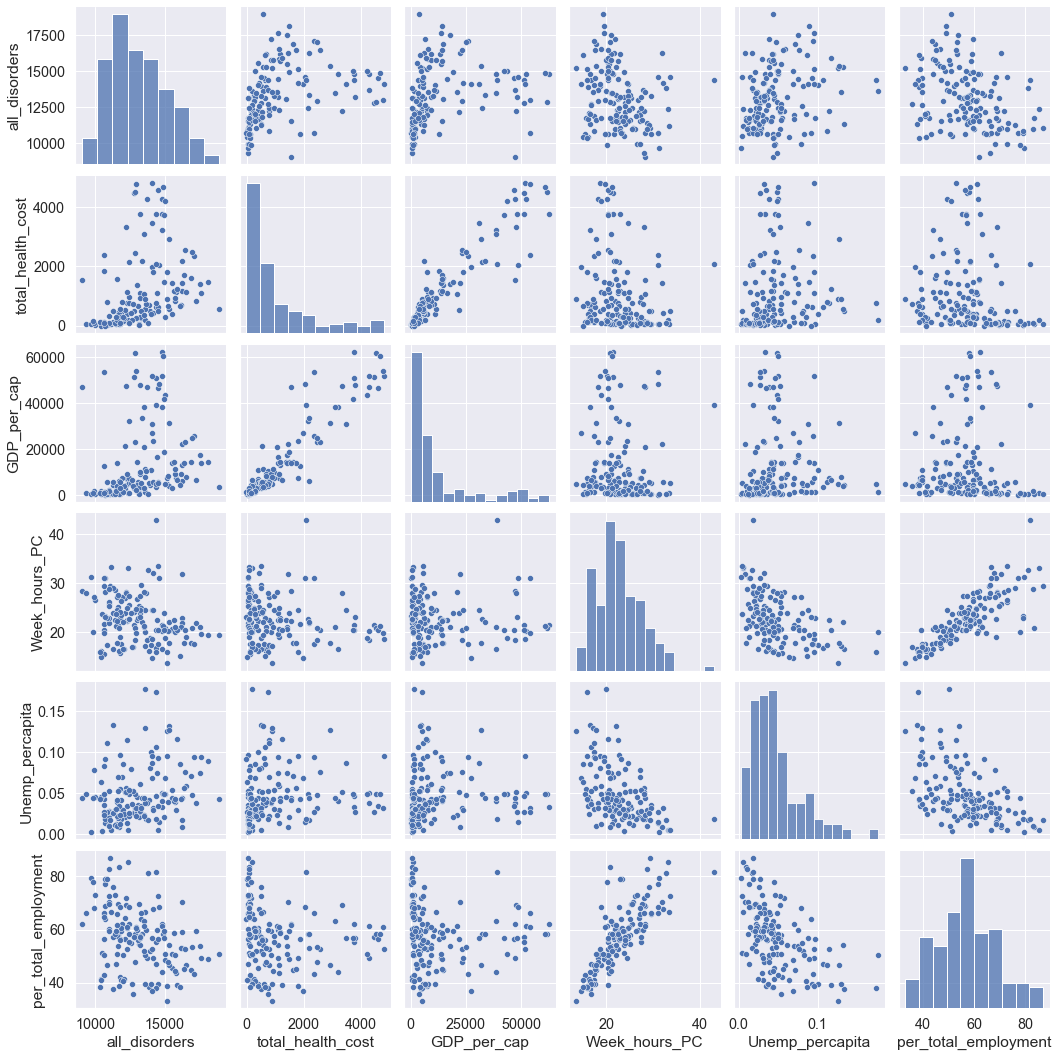

In [74]:
sns.pairplot(df_sc1)
plt.show()

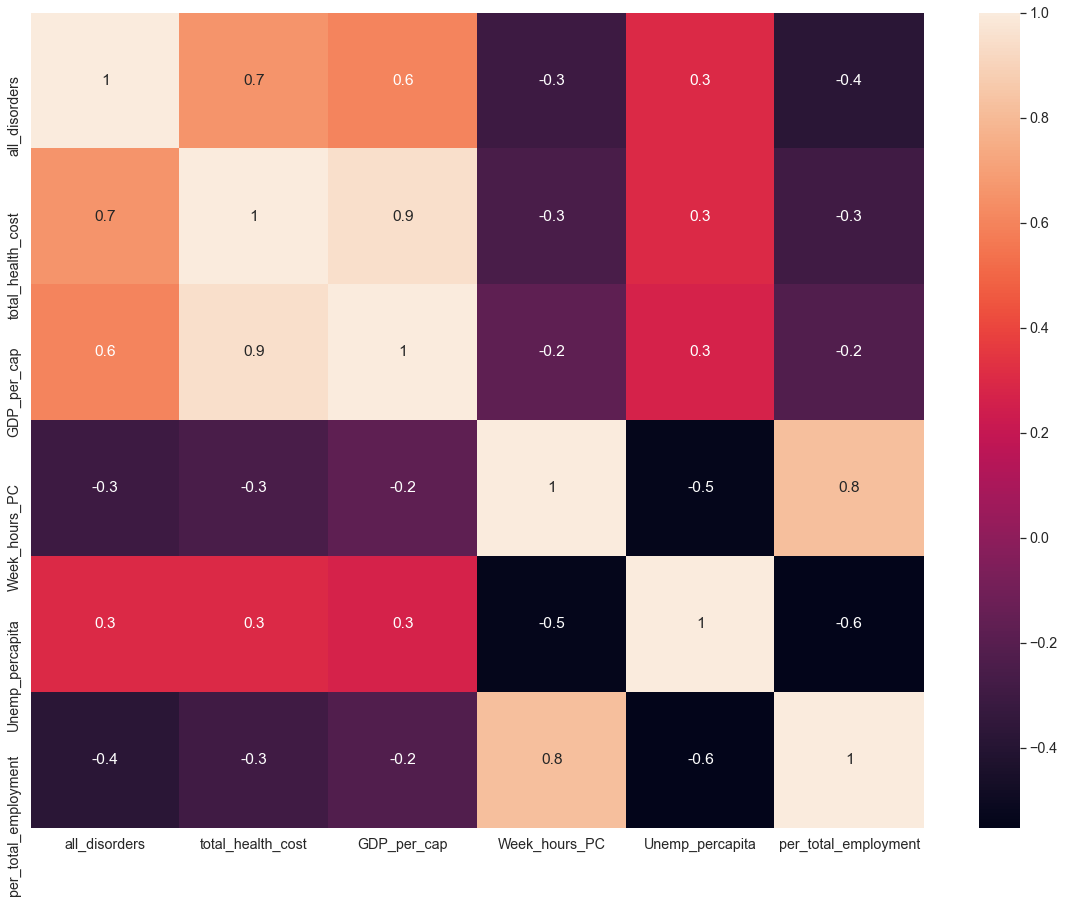

In [75]:
#correlation map:

sns.set(font_scale=1.3)
df_corr = df_sc1.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g') 
plt.show()

1. __Week_hours_PC__ seems to be highly correlated (0.8) with __per_employment__ and none of these are highly correlated to any of the others, thus one of them should be removed -> we are going to __remove per_total_employment__ for now.
2. __Total_health_cost__ is highly correlated to __GDP_percap__ and __all_disorders__ which makes sense. The more developped the country, the more it can spend in health. Also the more disorders the country has, the more it needs to spend in health. We are going to remove the __total_health cost__ for now

In [76]:
df_sc1.drop(columns = ['total_health_cost','per_total_employment'],inplace = True)

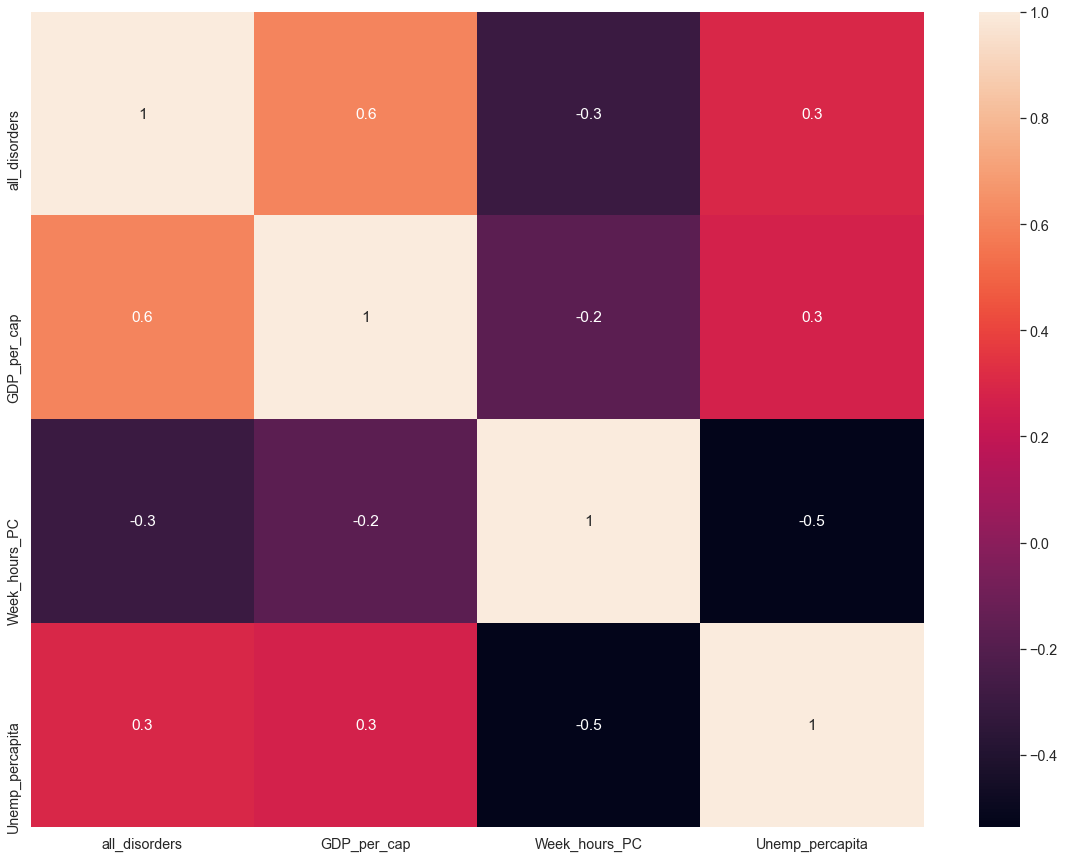

In [77]:
#correlation map:
sns.set(font_scale=1.3)
df_corr = df_sc1.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g') 
plt.show()

A bit better now. The highest correlation is between the GDP_percap and all_disorders. The more developped the country, the higher the percentage in work related disorders

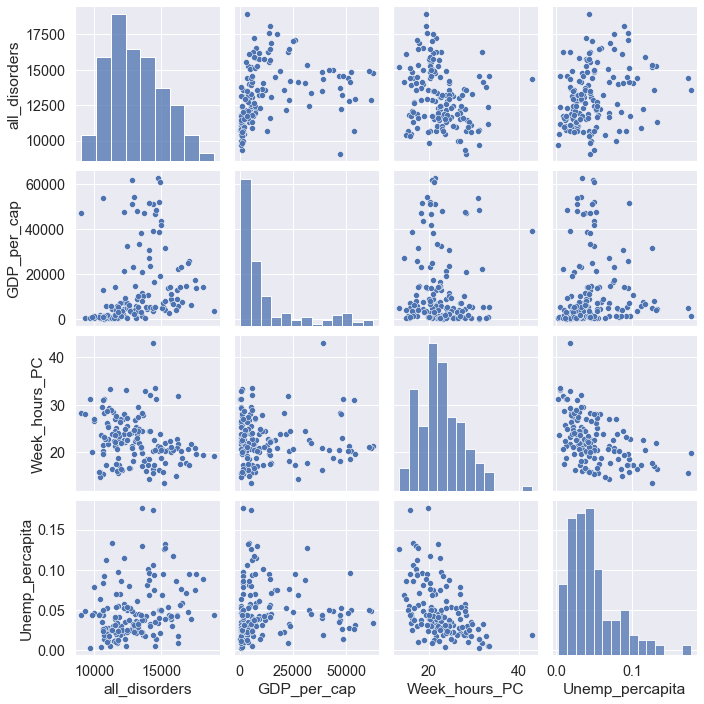

In [97]:
sns.pairplot(df_sc1)
plt.show()

In [95]:
df_sc1.skew()

all_disorders      0.443942
GDP_per_cap        1.626249
Week_hours_PC      0.748841
Unemp_percapita    1.414017
dtype: float64

In [96]:
df_sc1.kurt()

all_disorders     -0.447795
GDP_per_cap        1.490369
Week_hours_PC      1.134059
Unemp_percapita    2.197049
dtype: float64

### Transform the data using Power transformation
1. below we have a function to get the histograms of the transformed distributions. We will visually check which transformation follows a more normal distribution.
    1. sqrt: Square Root
    2. Cbrt: Cubic Root
    3. Log: Logaritmic

In [103]:
def pt_evaluation(df, evaluated_column):
    """ Evaluates the defined feature before and after applying power transformation. """
    
    # defining the power transformation class
    pt = PowerTransformer()

    # creating the evaluation data frame
    feature = df[[evaluated_column]]
    feature = feature.assign(log_transformation = np.log(feature[evaluated_column] + 1))
    feature = feature.assign(sqrt_transformation = np.sqrt(feature[evaluated_column]))
    feature = feature.assign(cbrt_transformation = np.cbrt(feature[evaluated_column]))
    #feature = feature.assign(yeo_johnson = pt.fit_transform(np.array(feature[evaluated_column]).reshape(-1, 1)))
    
    # represent the data
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    sns.histplot(data=feature, x=evaluated_column,  ax=axes[0])
    sns.histplot(data=feature, x='sqrt_transformation', ax=axes[1], legend=False)
    sns.histplot(data=feature, x='cbrt_transformation', ax=axes[2], legend=False)
    sns.histplot(data=feature, x='log_transformation', ax=axes[3], legend=False)
    #sns.histplot(data=feature, x='yeo_johnson', ax=axes[4], legend=False)

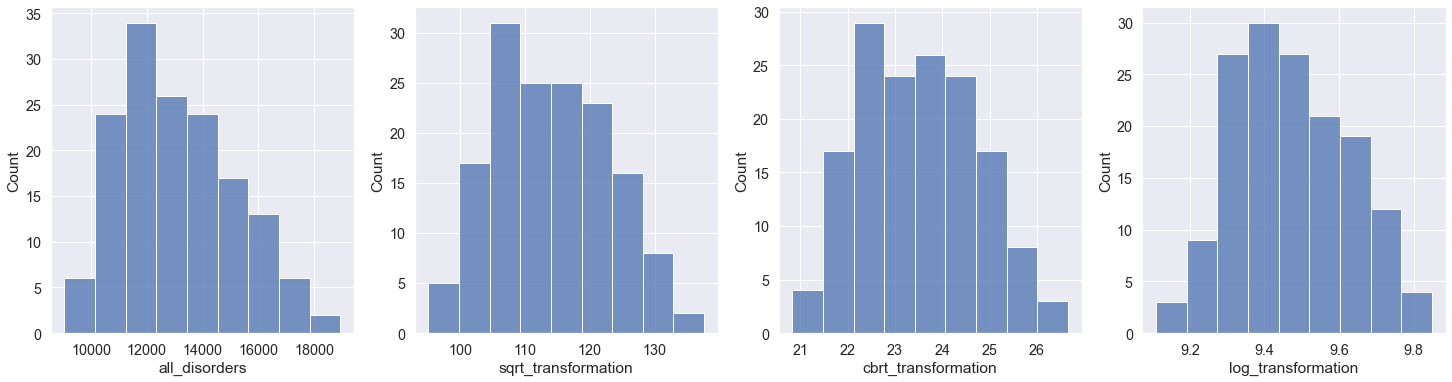

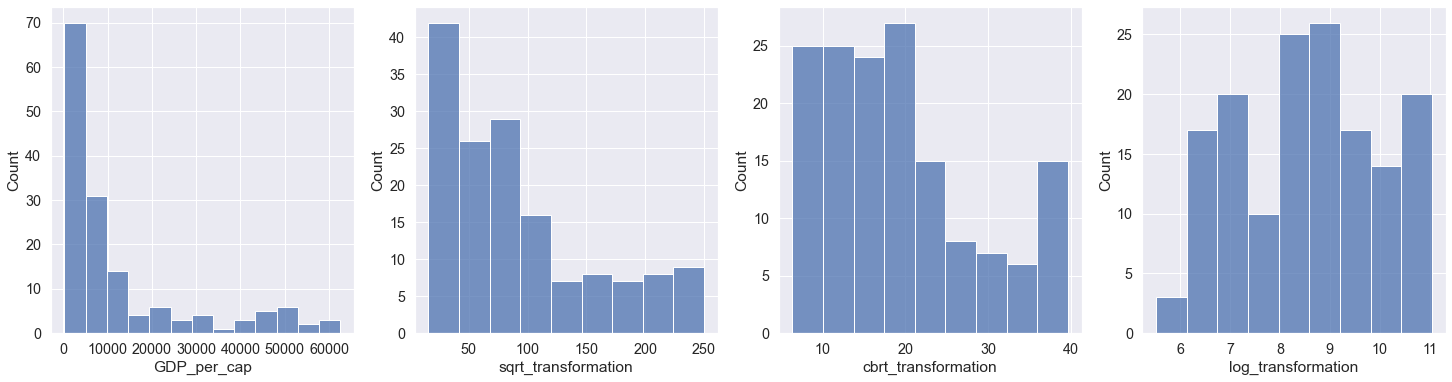

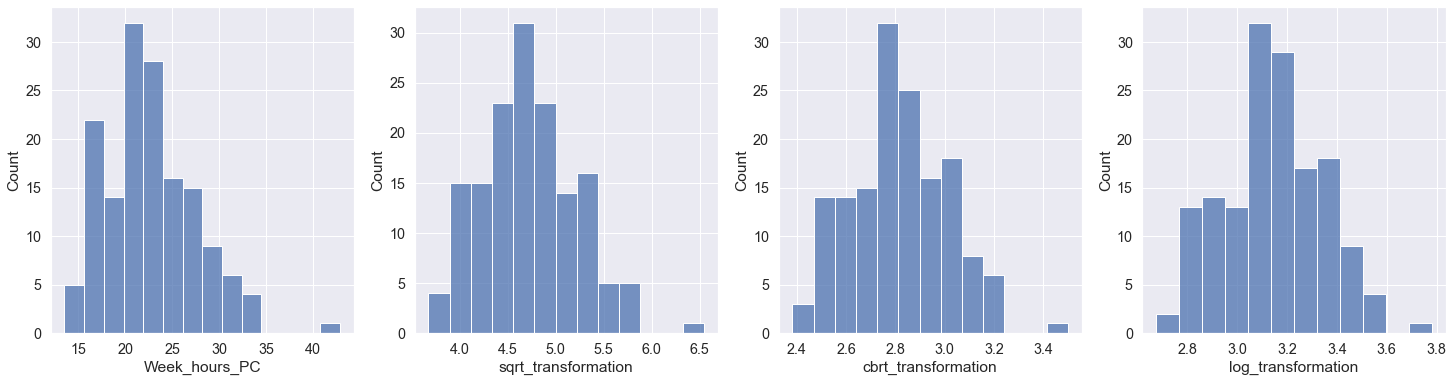

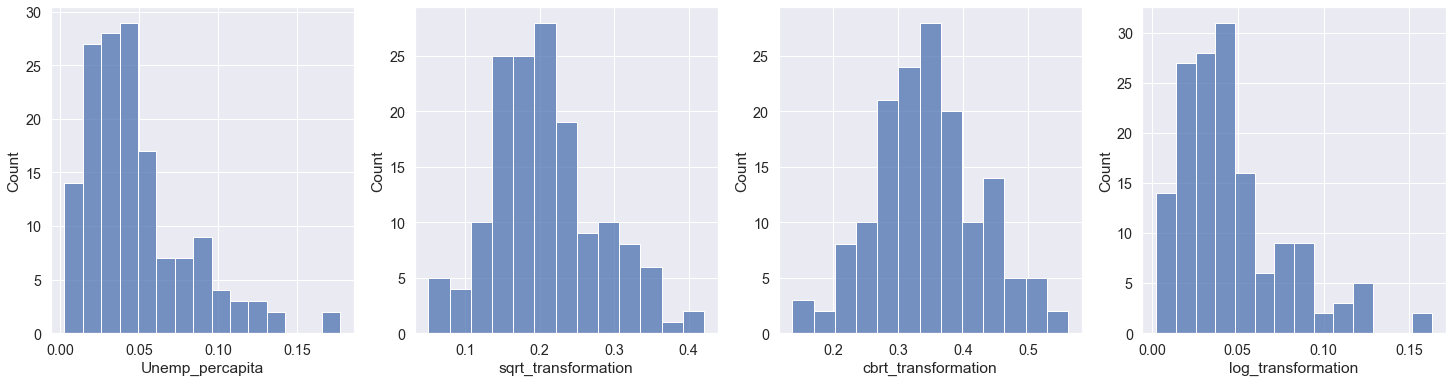

In [144]:
pt_evaluation(df_sc1, 'all_disorders')
pt_evaluation(df_sc1, 'GDP_per_cap')
pt_evaluation(df_sc1, 'Week_hours_PC')
pt_evaluation(df_sc1, 'Unemp_percapita')

1. __all disorders: cubic root__
2. __GDP_per_cap: logaritmic__
3. __Week_hours_PC: logaritmic__
4. __Unemp_percapita: cbrt_transformation__

In [122]:
df_sc1_t = df_sc1[[]]
df_sc1_t = df_sc1_t.assign(all_disorders_cb = np.cbrt(df_sc1['all_disorders']))
df_sc1_t = df_sc1_t.assign(GDP_PC_log = np.log(df_sc1['GDP_per_cap'] + 1))
df_sc1_t = df_sc1_t.assign(WH_PC_log = np.log(df_sc1['Week_hours_PC'] + 1))
df_sc1_t = df_sc1_t.assign(Unemp_PC_cb = np.cbrt(df_sc1['Unemp_percapita']))

In [123]:
df_sc1_t

,all_disorders_cb,GDP_PC_log,WH_PC_log,Unemp_PC_cb
location_name,,,,
Afghanistan,22.752358,6.383782,2.811177,0.380230
Albania,24.087852,8.397991,2.979809,0.432773
Algeria,24.043261,8.605801,2.842451,0.348456
Angola,23.028870,8.437385,3.370896,0.384791
Argentina,22.016123,9.461089,3.118579,0.351780
...,...,...,...,...
Uruguay,22.616543,9.563647,3.141311,0.346378
Uzbekistan,22.596448,7.563872,3.204212,0.315165
Vanuatu,22.745303,8.091180,2.991590,0.234507


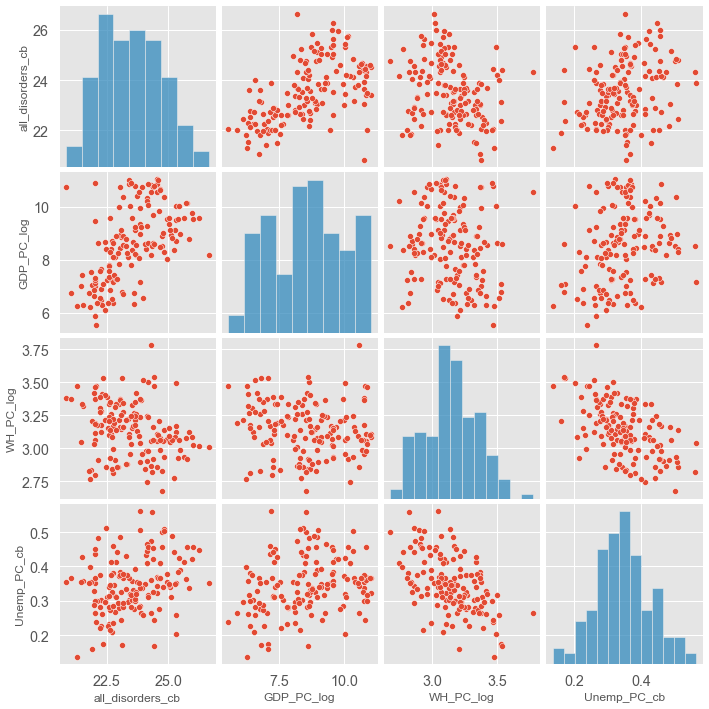

In [124]:
sns.pairplot(df_sc1_t)
plt.show()

### Normalize the data

In [101]:
minmax = MinMaxScaler()
minmax_sc1 = pd.DataFrame(minmax.fit_transform(df_sc_1), columns=df_sc_1.columns)

In [60]:
def evaluate_number_clusters(df, n):
    """ Evaluates the kmeans using different values of k. """
    
    # evalaution result list
    evaluation = []
    
    # evaluates different number of clusters
    for k in range(2, n):    

        # performs the kmeans cluster using the defined number of clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        silhoutte_score = silhouette_score(df, kmeans.labels_)

        # appends the results to the 
        evaluation.append([k, kmeans.inertia_, silhoutte_score])

    # converts the evaluation do df
    evaluation = pd.DataFrame(evaluation, columns=['k', 'error', 'silhouette'])

    # plots the evaluation
    fig, axes = plt.subplots(2,1, figsize = (14,6))
    sns.lineplot(data=evaluation, x='k', y='error', ax=axes[0], markers=True, marker="o")
    sns.lineplot(data=evaluation, x='k', y='silhouette', ax=axes[1], markers=True, marker="o")
    
    # saves the evaluation
    #fig.savefig(f'{prefix}_number_of_clusters_evaluation.png')

In [107]:
def evaluate_cluster(df_cluster, df_evaluate, k):
    """ Evaluate a specific number of cluster. """ 
    
    # applies the kmeans with specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    labels = kmeans.labels_
    
    # updates the cluster data
    df_cluster = df_cluster.assign(cluster = labels)
    
    # defines the number of columns to be evaluated
    columns = df_cluster.columns[:-1]
    n_columns = len(columns)
    
    # defines the standard height and width of the graphs
    graph_height = 6
    praph_width = 6
    
    # defines the number of columns and rows to be ploted
    n_columns_subplot = n_columns if n_columns <= 3 else 3
    if n_columns // 3 == 0 and n_columns != 3:
         n_rows_subplot = 1
    elif n_columns // 3 != 0 and n_columns % 3 == 0:
        n_rows_subplot = n_columns // 3 
    else:
        n_rows_subplot = n_columns // 3 + 1

    # calculates the total heigh and width
    total_height = graph_height * n_rows_subplot
    total_width = praph_width * n_columns_subplot
    
    # creates the subplot structure
    fig, axes = plt.subplots(n_rows_subplot, n_columns_subplot, figsize=(total_width, total_height))
    
    # defines the initial axis location of the plots
    if n_rows_subplot == 1:
        p = 0
    else:
        r = 0
        c = 0
    
    # plots all the columns
    for column in columns:
        if n_rows_subplot == 1:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[p], fill=True)
            p += 1
        else:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[r, c], fill=True)
            if c == n_columns_subplot-1:
                r += 1
                c = 0
            else:
                c += 1
            
    # saves the plot
    
    # shows the plot
    plt.show()
    
    # updates the evalutiaon data
    df_evaluate = df_evaluate.assign(labels=kmeans.labels_)
    
    # defines the evalaution metrics for each cluster
    metrics = {'labels': 'count'}
    for column in df_evaluate.columns:
        if column != 'labels':
            metrics[column] = ['mean', 'median','min','max']
    results = df_evaluate.groupby('labels').agg(metrics).round(2)
    
    return results.T

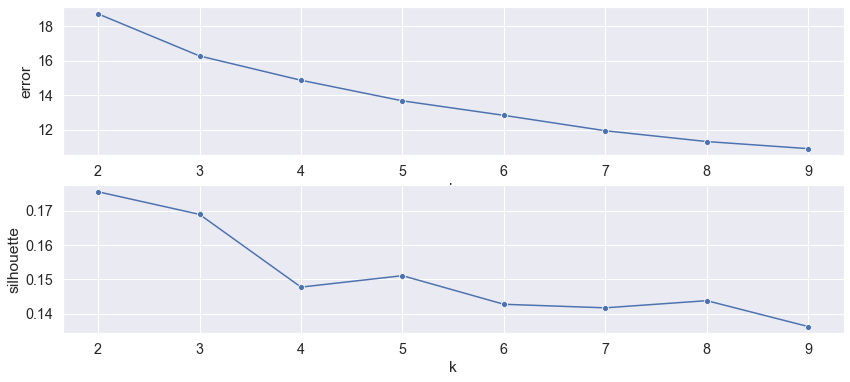

In [103]:
evaluate_number_clusters(minmax_sc1,10)

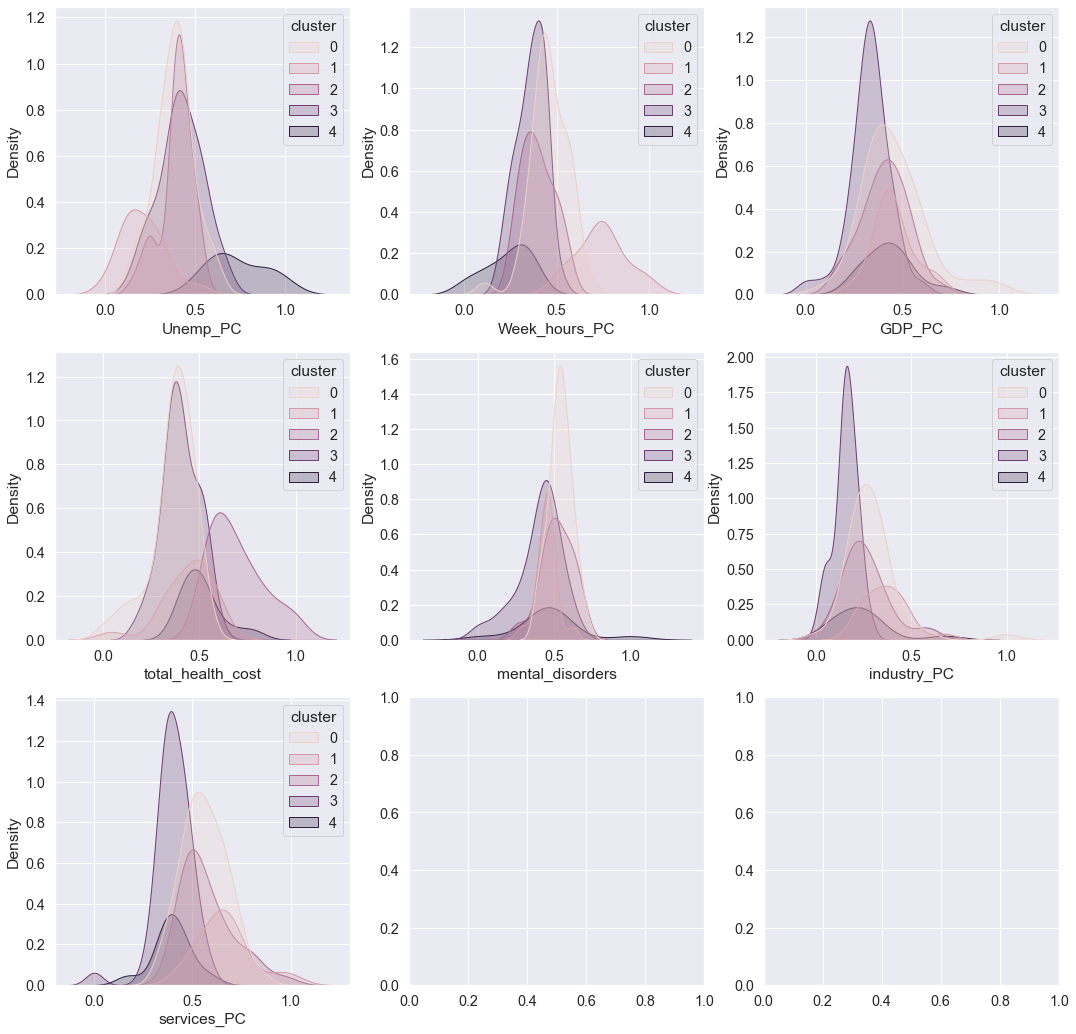

labels                         0      1       2      3       4
labels            count    45.00  18.00   30.00  42.00   12.00
Unemp_PC          mean     -8.69 -39.50   -6.38  -2.16   54.32
                  median   -6.77 -43.03   -4.39  -3.27   44.67
                  min     -50.11 -76.88  -47.45 -50.40   15.54
                  max      32.96  14.96   16.92  38.68  100.98
Week_hours_PC     mean      1.46  11.45   -0.79  -2.06   -6.60
                  median    1.05  11.53   -1.01  -1.78   -4.99
                  min     -11.09   3.04   -5.50  -8.14  -15.00
                  max       9.39  20.83    5.10   3.80   -1.88
GDP_PC            mean     13.53  12.75    3.95 -10.82    8.39
                  median    5.34   7.79    4.30 -10.69    7.47
                  min     -56.17 -27.52  -42.32 -73.79  -25.07
                  max     116.80  57.01   58.05  39.57   61.89
total_health_cost mean     15.79  29.07   74.02  22.81   42.55
                  median   19.48  35.52   69.57  20.86   39.60
                  min     -47.94 -40.31   43.46 -17.90   23.64
                  max      45.10  58.55  128.55  57.51   88.92
mental_disorders  mean      3.83   1.07    3.14  -0.45    1.69
                  median    3.91   1.26    3.11   0.55    1.58
                  min      -0.98  -3.86   -5.08 -12.66  -11.63
                  max       9.36   6.23    8.32   6.70   17.94
industry_PC       mean      7.66  16.06    4.60  -6.68    2.49
                  median    5.62  15.17    2.31  -6.24    1.28
                  min     -23.36   0.31  -19.41 -22.39  -13.45
                  max      83.87  48.91   41.49   7.68   49.21
services_PC       mean     10.54  15.86   11.37   2.39    2.11
                  median   10.14  15.44    8.79   1.86    1.82
                  min      -0.49   4.72    3.17 -18.19   -9.43
                  max      25.52  33.15   31.30  11.63   11.82

In [108]:
evaluate_cluster(minmax_sc1, df_sc_1, 5)

### Scenario 2:

1. Scenario 2: __Delta General Indicators__ (2011, 2017)
    1. Per_Total_employment
    2. Unem_percapita
    3. Week_hours_PC
    4. GDP_per_cap
    5. Total_health_cost
    6. All_disorders

In [171]:
complete_17 = merge2complete ('2017')
complete_17.isna().sum()

Anxiety disorders            0
Bipolar disorder             0
Depressive disorders         0
Dermatitis                   0
Musculoskeletal disorders    0
Public_cost                  6
Private_cost                 6
GDP_per_cap                  3
per_total_agriculture        0
per_total_employment         0
per_total_industry           0
per_total_services           0
Total_Labor_Force            0
Unemployment_rate            0
Weekly_work_hours            0
PopOver15                    1
Week_hours_PC                1
dtype: int64

In [167]:

complete_17_gb = (
    complete_17
    .pipe(predict_missing, 'Public_cost')
    .pipe(predict_missing, 'Private_cost')
    .pipe(predict_missing, 'GDP_per_cap')
)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

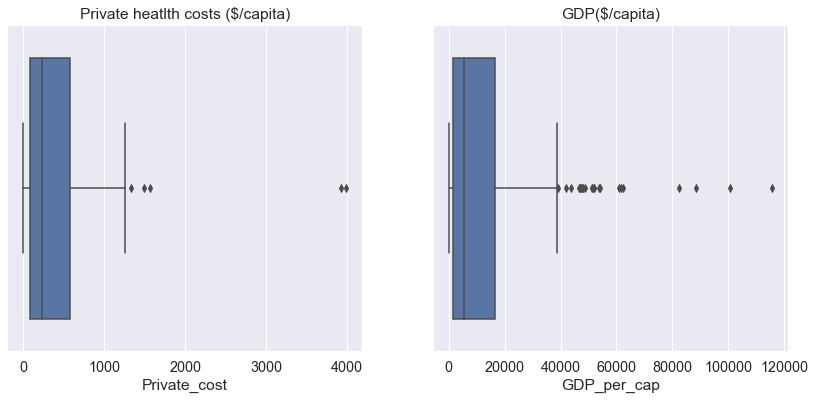

In [151]:
# check distribution of feature with highest kurtosis/skewness
fig, axes = plt.subplots(1,2, figsize = (14,6))
sns.boxplot(ax = axes[0], data = complete_17_gb, x = 'Private_cost').set(title='Private heatlth costs ($/capita)') 
sns.boxplot(ax = axes[1], data = complete_17_gb, x = 'GDP_per_cap').set(title='GDP($/capita)')
plt.show()

In [156]:
complete_17_gb.loc[complete_17_gb.Private_cost > 3500]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Weekly_work_hours,PopOver15,Week_hours_PC
location_name,,,,,,,,,,,,,,,,,
Liberia,546.592086,49.656894,4183.597501,4791.62441,2364.788293,1235.321289,3986.635742,596.897081,46.439999,73.839996,10.810000,42.750000,75.529999,2.24,74613436.0,2291263.0,32.564326
Switzerland,828.742223,62.869998,4806.902201,3253.03958,5676.299312,1924.072510,3916.969971,88415.628032,3.510000,64.489998,22.280001,74.209999,67.459999,4.40,161090739.0,6728881.0,23.940197


In [157]:
complete_17_gb.loc[complete_17_gb.GDP_per_cap > 80000]

,Anxiety disorders,Bipolar disorder,Depressive disorders,Dermatitis,Musculoskeletal disorders,Public_cost,Private_cost,GDP_per_cap,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,Total_Labor_Force,Unemployment_rate,Weekly_work_hours,PopOver15,Week_hours_PC
location_name,,,,,,,,,,,,,,,,,
Luxembourg,735.714819,61.670868,3880.999183,3291.846818,4910.542012,4802.062988,944.476929,115761.507705,1.23,54.070000,13.360000,85.410004,56.849998,4.90,8810917.0,428148.0,20.579139
Norway,907.309019,59.554391,3526.220844,3604.407771,5091.140820,4636.580566,855.496582,100600.562408,2.37,63.110001,20.250000,77.379997,65.199997,3.22,87927758.0,4027931.0,21.829509
Qatar,703.244860,61.305339,5466.014379,5052.915012,4378.810274,1459.370605,524.975403,82409.577333,1.36,86.330002,54.110001,44.540001,86.820000,0.56,76430339.0,1769481.0,43.193648
Switzerland,828.742223,62.869998,4806.902201,3253.039580,5676.299312,1924.072510,3916.969971,88415.628032,3.51,64.489998,22.280001,74.209999,67.459999,4.40,161090739.0,6728881.0,23.940197


In [158]:
#outliers removal
complete_17_no = complete_17_gb.drop(complete_17_gb[complete_17_gb['Private_cost'] > 3500].index)
complete_17_no.drop(complete_17_no[complete_17_no['GDP_per_cap'] > 80000].index,inplace = True)

In [160]:
feat_df_17 = feature_df(complete_17_no.copy())

In [161]:
delta_df = feat_df - feat_df_17

In [163]:
feat_df

,Dermatitis,Musculoskeletal disorders,GDP_per_cap,per_total_employment,Weekly_work_hours,PopOver15,Week_hours_PC,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,Unemp_percapita
location_name,,,,,,,,,,,,,,
Afghanistan,3871.050783,2553.754594,591.162759,42.259998,246178863.0,15750928.0,15.629483,5353.402357,108.015223,11778.207734,0.226345,0.062333,0.133922,0.054972
Albania,5342.053593,5562.496536,4437.142885,52.020000,42626014.0,2281412.0,18.684049,3071.813878,480.215637,13976.364008,0.236119,0.098162,0.185972,0.081055
Algeria,4658.153190,3818.968263,5462.260897,38.250000,429625147.0,26589391.0,16.157766,5421.767746,687.132324,13898.889198,0.041195,0.118040,0.223265,0.042310
Angola,4353.703965,2231.893258,4615.468028,71.709999,359793509.0,12801943.0,28.104602,5627.276225,163.096699,12212.873448,0.367299,0.057081,0.292720,0.056974
Argentina,3272.640898,3664.050241,12848.864197,56.279999,661542898.0,30606837.0,21.614220,3734.736042,1852.966370,10671.427182,0.003602,0.134903,0.424295,0.043532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,3284.293357,4009.637019,14236.681188,61.709999,58225867.0,2630586.0,22.134181,4274.611940,1553.247559,11568.542317,0.060414,0.128233,0.428453,0.041558
Uzbekistan,4971.260100,3252.197225,1926.292997,59.480000,493142227.0,20863950.0,23.636091,3314.277117,280.536118,11537.734442,0.161131,0.135258,0.298411,0.031305
Vanuatu,4681.507176,4114.927143,3264.537017,68.419998,2826305.0,149403.0,18.917324,2970.821677,78.496647,11767.255997,0.438572,0.047347,0.198281,0.012896


In [164]:
feat_df_17

,Dermatitis,Musculoskeletal disorders,GDP_per_cap,per_total_employment,Weekly_work_hours,PopOver15,Week_hours_PC,mental_disorders,total_health_cost,all_disorders,agriculture_percap,industry_percap,services_percap,Unemp_percapita
location_name,,,,,,,,,,,,,,
Afghanistan,3871.050783,2553.754594,591.162759,42.259998,246178863.0,15750928.0,15.629483,5353.402357,108.015223,11778.207734,0.226345,0.062333,0.133922,0.054972
Albania,5342.053593,5562.496536,4437.142885,52.020000,42626014.0,2281412.0,18.684049,3071.813878,480.215637,13976.364008,0.236119,0.098162,0.185972,0.081055
Algeria,4658.153190,3818.968263,5462.260897,38.250000,429625147.0,26589391.0,16.157766,5421.767746,687.132324,13898.889198,0.041195,0.118040,0.223265,0.042310
Angola,4353.703965,2231.893258,4615.468028,71.709999,359793509.0,12801943.0,28.104602,5627.276225,163.096699,12212.873448,0.367299,0.057081,0.292720,0.056974
Argentina,3272.640898,3664.050241,12848.864197,56.279999,661542898.0,30606837.0,21.614220,3734.736042,1852.966370,10671.427182,0.003602,0.134903,0.424295,0.043532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,3284.293357,4009.637019,14236.681188,61.709999,58225867.0,2630586.0,22.134181,4274.611940,1553.247559,11568.542317,0.060414,0.128233,0.428453,0.041558
Uzbekistan,4971.260100,3252.197225,1926.292997,59.480000,493142227.0,20863950.0,23.636091,3314.277117,280.536118,11537.734442,0.161131,0.135258,0.298411,0.031305
Vanuatu,4681.507176,4114.927143,3264.537017,68.419998,2826305.0,149403.0,18.917324,2970.821677,78.496647,11767.255997,0.438572,0.047347,0.198281,0.012896
